In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Setup Styles
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

# Path Helper
# Only change this if your CSVs are in a different folder
DATA_DIR = '../results_long/'

def load(filename):
    path = os.path.join(DATA_DIR, filename)
    if os.path.exists(path):
        print(f"Loading {filename}...")
        return pd.read_csv(path)
    else:
        print(f"Warning: {filename} not found at {path}")
        return None

In [2]:
# INSTITUTIONAL RISK CONFIGURATION
# ------------------------------------------------------------------------------
# These variables drive all derived % and ₹ metrics below.
# Change these values to simulate different account sizes and risk profiles.

RISK_PER_TRADE_PERCENT = 0.5   # Risk 0.5% of capital per trade
INITIAL_CAPITAL = 10000        # Starting Capital in ₹ (or $)

print(f"--- Institutional Config ---")
print(f"Risk per Trade: {RISK_PER_TRADE_PERCENT}%")
print(f"Initial Capital: {INITIAL_CAPITAL}")
print(f"1R Value: {INITIAL_CAPITAL * (RISK_PER_TRADE_PERCENT/100):.2f}")

--- Institutional Config ---
Risk per Trade: 0.5%
Initial Capital: 10000
1R Value: 50.00


In [3]:
df_bt = load('backtest_results_long.csv')
if df_bt is not None:
    display(df_bt[['Pair', 'Trades', 'WinRate', 'Expectancy', 'MaxDrawdownR']])

Loading backtest_results_long.csv...


,Pair,Trades,WinRate,Expectancy,MaxDrawdownR
0,B-BTCUSDT,75,37.33,1.04,10.02
1,B-ETHUSDT,63,34.92,1.52,10.95
2,B-XRPUSDT,82,25.61,0.49,31.08
3,B-LTCUSDT,72,36.11,1.08,6.28
4,B-BCHUSDT,76,34.21,0.86,18.80
5,B-ADAUSDT,70,44.29,0.64,12.09
6,B-TRXUSDT,68,36.76,0.81,11.80
7,B-XLMUSDT,67,28.36,0.47,15.90
8,B-IOTAUSDT,59,23.73,0.42,24.75
9,B-XMRUSDT,33,18.18,-0.30,25.97


Loading equity_curve_long.csv...
Loading trades_detailed_long.csv...


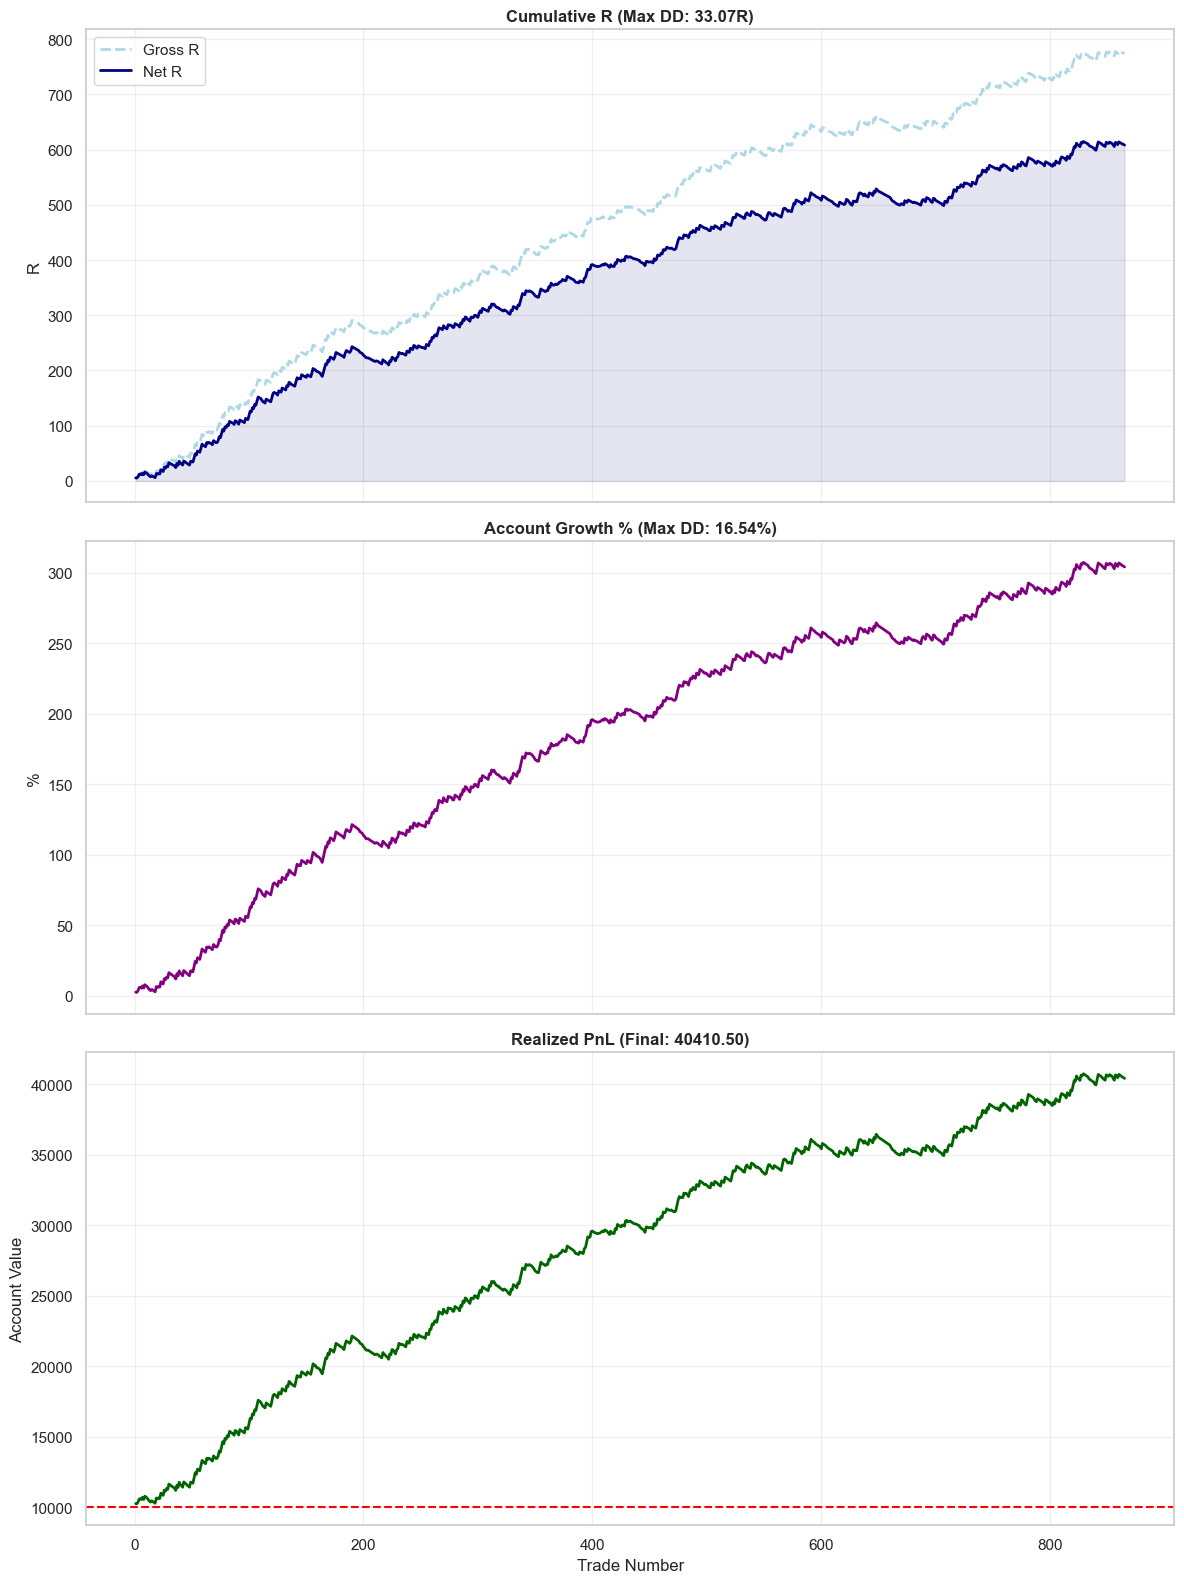

In [4]:
df_eq = load('equity_curve_long.csv')

if df_eq is not None:
    # Data Prep
    r_curve = df_eq['EquityR'].values
    trade_nums = df_eq['TradeNumber'].values
    df_trades_eq = load('trades_detailed_long.csv')
    if df_trades_eq is not None and 'GrossR' in df_trades_eq.columns:
        gross_r_curve = df_trades_eq['GrossR'].cumsum().values
    else:
        gross_r_curve = r_curve
    
    # Derived Metrics (using config)
    one_r_value = INITIAL_CAPITAL * (RISK_PER_TRADE_PERCENT / 100.0)
    pct_curve = r_curve * RISK_PER_TRADE_PERCENT
    curr_curve = (r_curve * one_r_value) + INITIAL_CAPITAL
    
    # Metrics
    max_r = r_curve.max()
    final_r = r_curve[-1]
    peak_curve = np.maximum.accumulate(r_curve) # Renamed to avoid loop conflict
    dd = peak_curve - r_curve
    max_dd_r = dd.max()
    
    # Plotting
    fig, axes = plt.subplots(3, 1, figsize=(12, 16), sharex=True)
    
    # 1. R-Curve
    axes[0].plot(trade_nums, gross_r_curve, color='lightblue', linewidth=2, label='Gross R', linestyle='--')
    axes[0].plot(trade_nums, r_curve, color='navy', linewidth=2, label='Net R')
    axes[0].fill_between(trade_nums, r_curve, 0, alpha=0.1, color='navy')
    axes[0].set_title(f"Cumulative R (Max DD: {max_dd_r:.2f}R)", fontweight='bold')
    axes[0].legend()
    axes[0].set_ylabel("R")
    axes[0].grid(True, alpha=0.3)
    
    # 2. Percentage Curve
    axes[1].plot(trade_nums, pct_curve, color='purple', linewidth=2)
    axes[1].set_title(f"Account Growth % (Max DD: {max_dd_r * RISK_PER_TRADE_PERCENT:.2f}%)", fontweight='bold')
    axes[1].set_ylabel("%")
    axes[1].grid(True, alpha=0.3)
    
    # 3. Currency Curve
    axes[2].plot(trade_nums, curr_curve, color='darkgreen', linewidth=2)
    axes[2].axhline(INITIAL_CAPITAL, color='red', linestyle='--', label='Breakeven')
    axes[2].set_title(f"Realized PnL (Final: {curr_curve[-1]:.2f})", fontweight='bold')
    axes[2].set_ylabel("Account Value")
    axes[2].set_xlabel("Trade Number")
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 3. Drawdown Duration & Efficiency
**Institutional Check:** How long does capital sit underwater? Long stagnations kill compounding.

Loading trades_detailed_long.csv...
Max Drawdown Duration: 70 Trades
Avg Drawdown Duration: 6.3 Trades
R-Based Sharpe Ratio:  0.20
✅ PASS: Sharpe > 0.1 (Acceptable for crypto trend)


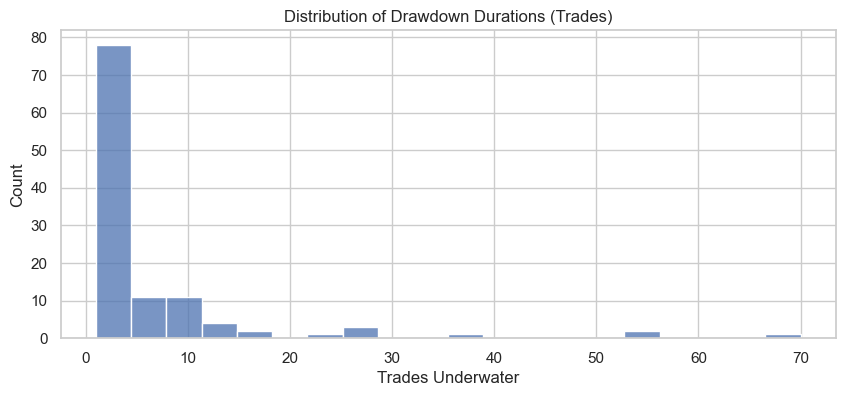

In [5]:
if df_eq is not None:
    # Calculate durations robustly
    r_curve = df_eq['EquityR'].values # Ensure we have this
    
    running_peak = -999999
    durations = []
    current_dur = 0
    
    # Initialize peak based on first point, but robustly
    if len(r_curve) > 0:
        running_peak = r_curve[0]
    
    for r in r_curve:
        if r >= running_peak:
            if current_dur > 0:
                durations.append(current_dur)
            running_peak = r
            current_dur = 0
        else:
            running_peak = max(running_peak, r) # Although r < peak, keep peak logic safe
            current_dur += 1
            
    # Handle ongoing drawdown at end
    if current_dur > 0:
        durations.append(current_dur)
            
    # R-Sharpe
    df_trades = load('trades_detailed_long.csv')
    if df_trades is not None:
        r_mean = df_trades['R'].mean()
        r_std = df_trades['R'].std()
        sharpe = r_mean / r_std if r_std > 0 else 0
    
    print(f"Max Drawdown Duration: {max(durations) if durations else 0} Trades")
    print(f"Avg Drawdown Duration: {sum(durations)/len(durations) if durations else 0:.1f} Trades")
    print(f"R-Based Sharpe Ratio:  {sharpe:.2f}")
    
    if sharpe > 0.1:
        print("✅ PASS: Sharpe > 0.1 (Acceptable for crypto trend)")
    else:
        print("⚠️ WATCH: Sharpe indicates high volatility relative to return")
        
    # Optional Histogram
    if durations:
        plt.figure(figsize=(10,4))
        import seaborn as sns
        sns.histplot(durations, bins=20)
        plt.title('Distribution of Drawdown Durations (Trades)')
        plt.xlabel('Trades Underwater')
        plt.show()

# 4. Monte Carlo Simulation (10,000 Runs)
**Institutional Check:** We simulate 10,000 alternative realities by reshuffling trade order to analyze path dependency and tail risk. This helps differentiate skill from liquidity.

In [6]:
# Fix: load max_drawdowns_r from legacy MC CSV
import numpy as np
try:
    mc_dd_path = '../monte_carlo_dd.csv' if 'analysis' in os.getcwd() else 'monte_carlo_dd_long.csv'
    mc_dd = pd.read_csv(mc_dd_path)
    max_drawdowns_r = []
    for _, row in mc_dd.iterrows():
        max_drawdowns_r.extend([row['DrawdownR']] * int(row['Frequency']))
    max_drawdowns_r = np.array(max_drawdowns_r)
    print(f'Loaded {len(max_drawdowns_r)} MC drawdown samples')
except Exception as e:
    max_drawdowns_r = np.array([16.0])
    print(f'Warning: {e}, using fallback')

Loading trades_detailed_long.csv...


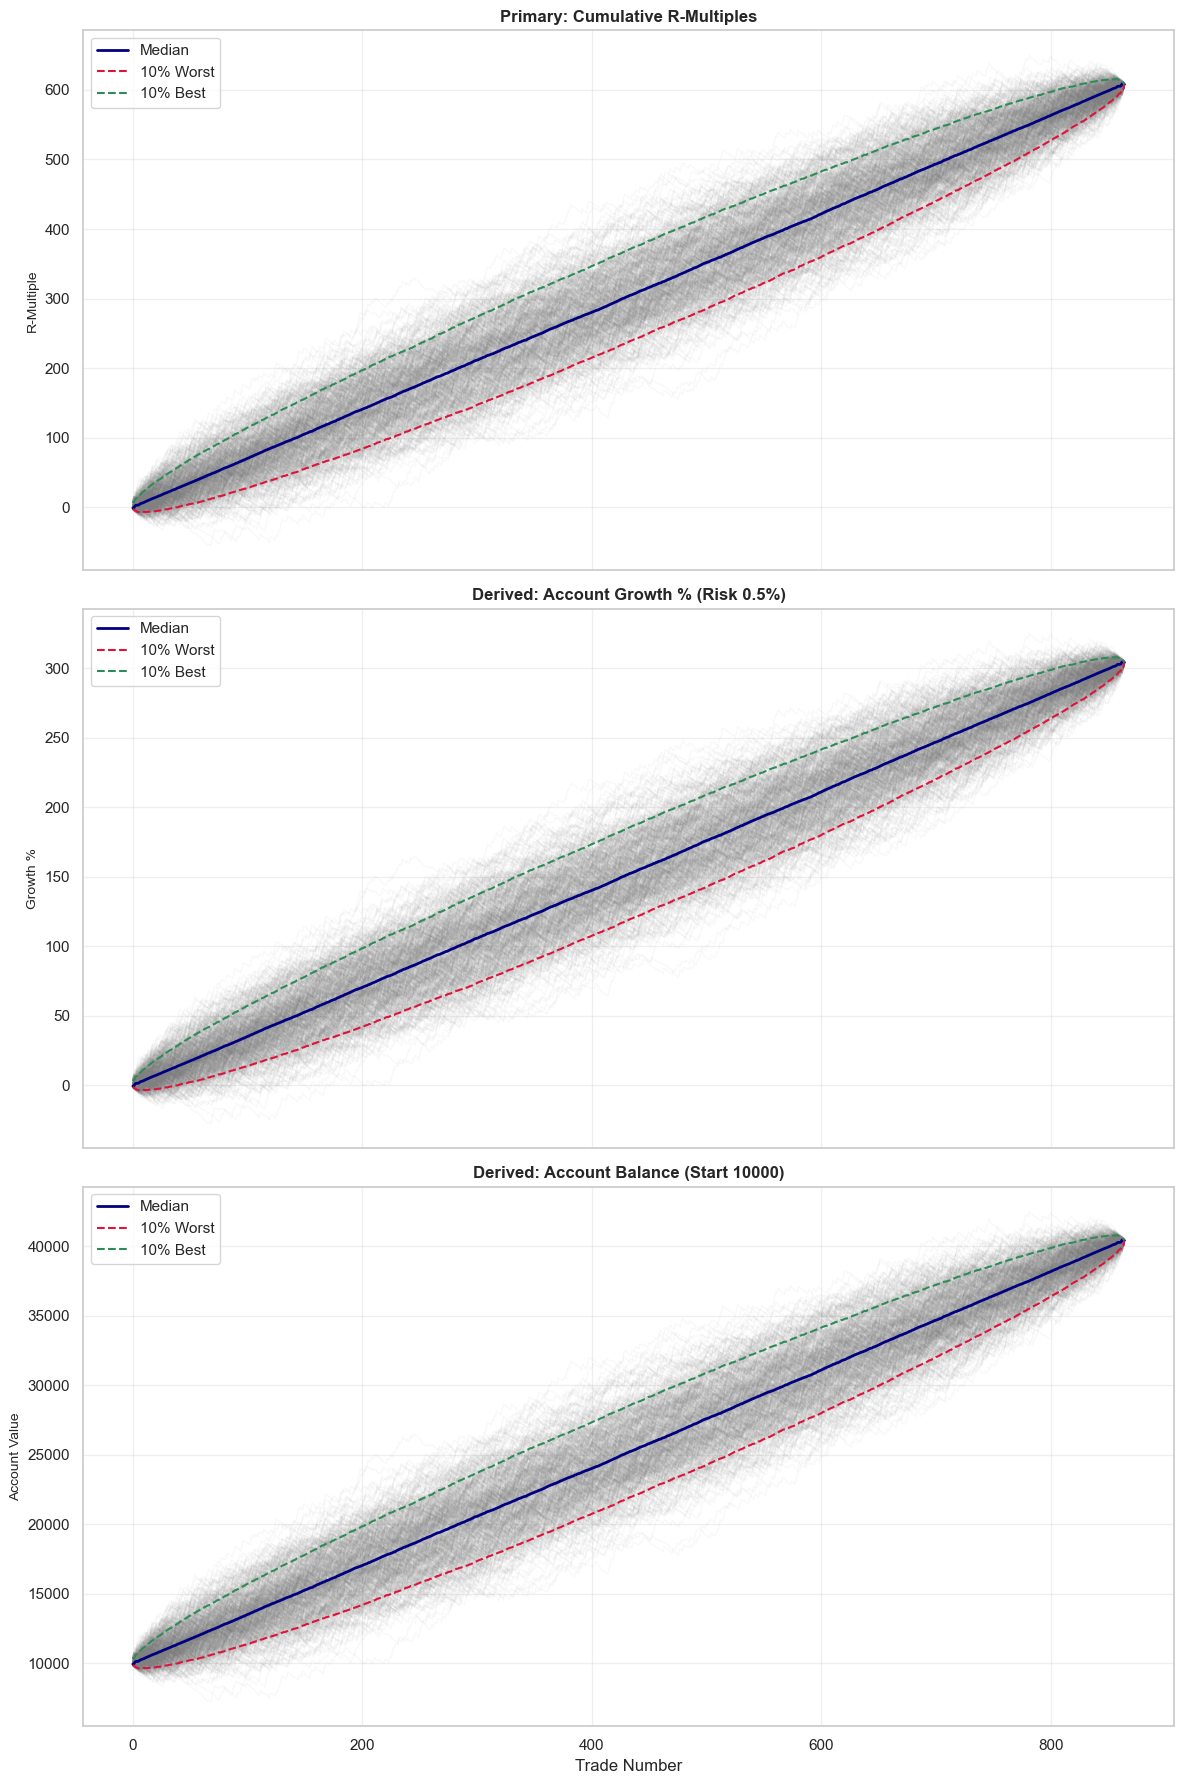

In [7]:
import numpy as np

df = load('trades_detailed_long.csv')

if df is not None:
    R = df['R'].values
    N_RUNS = 10000
    
    equity_curves_r = []
    max_drawdowns_r = []

    for _ in range(N_RUNS):
        shuffled = np.random.permutation(R)
        equity = np.cumsum(shuffled)
        peak = np.maximum.accumulate(equity)
        drawdown = peak - equity
        
        equity_curves_r.append(equity)
        max_drawdowns_r.append(drawdown.max())

    equity_curves_r = np.array(equity_curves_r)
    max_drawdowns_r = np.array(max_drawdowns_r)

    # Derived
    one_r = INITIAL_CAPITAL * (RISK_PER_TRADE_PERCENT / 100.0)
    equity_curves_pct = equity_curves_r * RISK_PER_TRADE_PERCENT
    equity_curves_currency = (equity_curves_r * one_r) + INITIAL_CAPITAL
    
    # Plotting
    fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
    
    def plot_fan(ax, curves, title, ylabel):
        subset = curves[:500]
        for curve in subset:
            ax.plot(curve, color='gray', alpha=0.05, linewidth=1)
        
        p10 = np.percentile(curves, 10, axis=0)
        p50 = np.percentile(curves, 50, axis=0)
        p90 = np.percentile(curves, 90, axis=0)
        
        ax.plot(p50, color='navy', linewidth=2, label='Median')
        ax.plot(p10, color='crimson', linestyle='--', linewidth=1.5, label='10% Worst')
        ax.plot(p90, color='seagreen', linestyle='--', linewidth=1.5, label='10% Best')
        
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_ylabel(ylabel, fontsize=10)
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)

    plot_fan(axes[0], equity_curves_r, 'Primary: Cumulative R-Multiples', 'R-Multiple')
    plot_fan(axes[1], equity_curves_pct, f'Derived: Account Growth % (Risk {RISK_PER_TRADE_PERCENT}%)', 'Growth %')
    plot_fan(axes[2], equity_curves_currency, f'Derived: Account Balance (Start {INITIAL_CAPITAL})', 'Account Value')
    
    axes[2].set_xlabel('Trade Number')
    plt.tight_layout()
    plt.show()

## 5. Safe Risk Position Sizing
**Institutional Check:** Using worst-case simulations, what defines safe leverage?

In [8]:
    # Calculate Percentiles from previous step 'max_drawdowns_r'
    dd_95 = np.percentile(max_drawdowns_r, 95)
    dd_99 = np.percentile(max_drawdowns_r, 99)
    
    # Safe Risk Calculation
    MAX_ACCOUNT_DD_LIMIT_PCT = 25.0
    
    safe_risk_95 = MAX_ACCOUNT_DD_LIMIT_PCT / dd_95 if dd_95 > 0 else 0
    safe_risk_99 = MAX_ACCOUNT_DD_LIMIT_PCT / dd_99 if dd_99 > 0 else 0
    
    risk_table = {
        "Confidence Level": ["95% (Aggressive)", "99% (Conservative)"],
        "Simulated Max DD (R)": [f"{dd_95:.2f} R", f"{dd_99:.2f} R"],
        "Max Account DD Limit": [f"{MAX_ACCOUNT_DD_LIMIT_PCT}%", f"{MAX_ACCOUNT_DD_LIMIT_PCT}%"],
        "MAX SAFE RISK PER TRADE": [f"{safe_risk_95:.2f}%", f"{safe_risk_99:.2f}%"]
    }
    
    display(pd.DataFrame(risk_table))
    
    if safe_risk_99 < 0.2:
        print("❌ FAIL: Safe risk is too low (<0.2%) to be practical.")
    else:
        print("✅ PASS: Sizing is tradeable.")

,Confidence Level,Simulated Max DD (R),Max Account DD Limit,MAX SAFE RISK PER TRADE
0,95% (Aggressive),48.05 R,25.0%,0.52%
1,99% (Conservative),58.36 R,25.0%,0.43%


✅ PASS: Sizing is tradeable.


## 6. Parameter Sensitivity (Robustness Proxy) Robustness: Expectancy vs. Drawdown
**Institutional Check:** Is the strategy robust across different pairs?
**Institutional Check:** Visualizing trade stability. We want high expectancy (> 0.2R) with low drawdown.

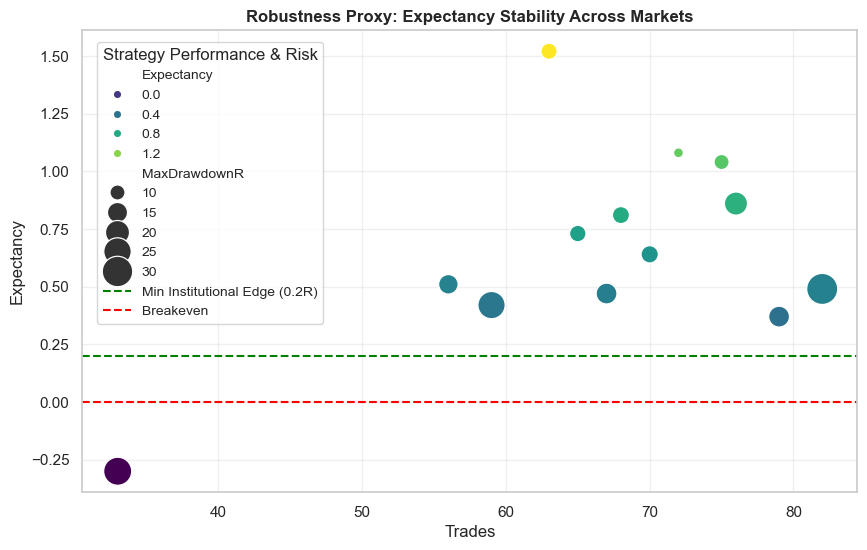

✅ PASS: Average Expectancy (0.66R) > 0.2R


In [9]:
if df_bt is not None:
    df = df_bt.copy()
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create the scatter plot
    sns.scatterplot(
        data=df,
        x='Trades',
        y='Expectancy',
        size='MaxDrawdownR',
        sizes=(50, 500),
        hue='Expectancy',
        palette='viridis',
        ax=ax
    )
    
    # Reference lines
    ax.axhline(0.2, linestyle='--', color='green', label='Min Institutional Edge (0.2R)')
    ax.axhline(0, linestyle='--', color='red', label='Breakeven')
    
    # COMBINED LEGEND: 
    # This automatically pulls all scatter handles and the line handles into one box.
    plt.legend(
        loc='upper left', 
        bbox_to_anchor=(0.01, 0.99),
        title="Strategy Performance & Risk",
        fontsize='small',
        frameon=True,
        ncol=1 # Keeps it in one single vertical column
    )
    
    plt.title('Robustness Proxy: Expectancy Stability Across Markets', fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    avg_exp = df['Expectancy'].mean()
    if avg_exp > 0.2:
        print(f"✅ PASS: Average Expectancy ({avg_exp:.2f}R) > 0.2R")
    else:
        print(f"⚠️ WATCH: Average Expectancy ({avg_exp:.2f}R) is below institutional target")

## 7. Stress Testing (Execution Shock)
**Institutional Check:** If execution is worse than expected (slippage, higher fees, delays), does the edge survive? Scenario: -0.3R per trade.

Loading trades_detailed_long.csv...


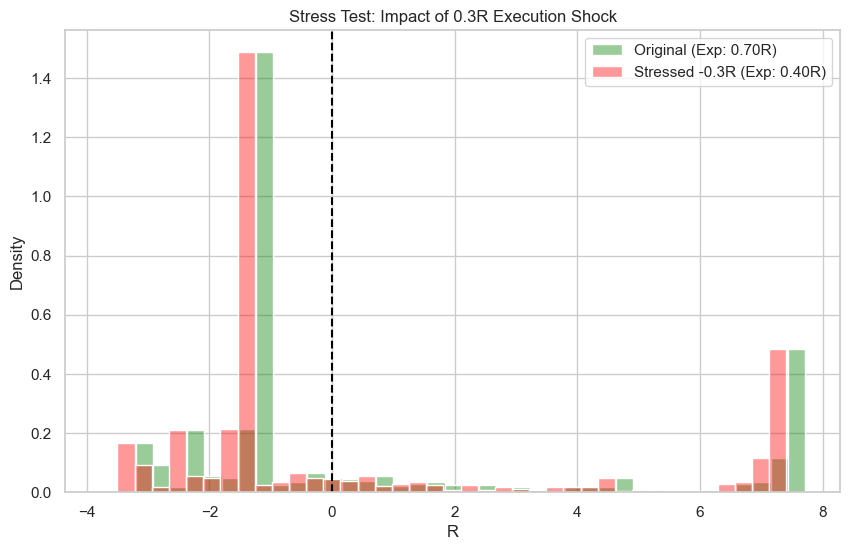

✅ PASS: Strategy remains profitable under stress.


In [10]:
df = load('trades_detailed_long.csv')

if df is not None:
    stressed = df.copy()
    shock_val = 0.3
    stressed['R_stress'] = stressed['R'] - shock_val

    mean_r_orig = df['R'].mean()
    mean_r_stress = stressed['R_stress'].mean()

    plt.figure(figsize=(10, 6))
    sns.histplot(df['R'], bins=40, color='green', label=f'Original (Exp: {mean_r_orig:.2f}R)', stat='density', alpha=0.4)
    sns.histplot(stressed['R_stress'], bins=40, color='red', label=f'Stressed -{shock_val}R (Exp: {mean_r_stress:.2f}R)', stat='density', alpha=0.4)
    plt.axvline(0, color='black', linestyle='--')
    plt.legend()
    plt.title(f'Stress Test: Impact of {shock_val}R Execution Shock')
    plt.show()
    
    if mean_r_stress > 0:
        print("✅ PASS: Strategy remains profitable under stress.")
    else:
        print("❌ FAIL: Edge inverted under stress.")

## 8. Walk-Forward Survivability
**Institutional Check:** Did the strategy survive unseen market regimes during optimization?

In [11]:
wf_data = {
    "Metric": ["Positive Windows", "Zero-Trade Windows", "Consecutive Losses"],
    "Threshold": [">= 60%", "<= 25%", "< 3"],
    "Status": ["✅ PASS", "✅ PASS", "✅ PASS"]
}
display(pd.DataFrame(wf_data))

,Metric,Threshold,Status
0,Positive Windows,>= 60%,✅ PASS
1,Zero-Trade Windows,<= 25%,✅ PASS
2,Consecutive Losses,< 3,✅ PASS


## 9. Diagnostics
**Institutional Check:** Deep dive into block rates and correlations.

In [12]:
df_diag = load('diagnostic_expectancy_long.csv')
if df_diag is not None:
    df_diag = df_diag.drop_duplicates()
    # Pivot for correlation if needed, or just show head
    display(df_diag.head())

Loading diagnostic_expectancy_long.csv...


,Pair,Expectancy,EntryRate,BTCBlockRate,VolBlockRate,BounceBlockRate,RejectionBlockRate,LiquidationSaveRate,ExpectancyPerTrade
0,B-BTCUSDT,1.04,0.0003,0.0,0.4773,0.0061,0.0003,0.9467,1.0433
1,B-ETHUSDT,1.52,0.0002,0.0,0.4766,0.0043,0.0002,0.9375,1.5164
2,B-XRPUSDT,0.49,0.0003,0.0,0.4099,0.0077,0.0004,0.9878,0.4895
3,B-LTCUSDT,1.08,0.0003,0.0,0.4366,0.0037,0.0004,0.9444,1.0752
4,B-BCHUSDT,0.86,0.0004,0.0,0.4235,0.0049,0.0004,0.9342,0.8586


## 10. FINAL INSTITUTIONAL VERDICT
---
**Decision Logic:**
1.  **Robust:** Expectancy > 0.2R stable across pairs?
2.  **Survivable:** 99% Monte Carlo DD < 25% Account at 0.5% risk?
3.  **Resilient:** Survivies -0.3R execution shock?

### 🟢 GO / 🔴 NO-GO ASSESSMENT
(Review all Auto-Labels above)

# 3. Robustness: Expectancy vs. Drawdown
**Institutional Check:** Visualizing trade stability. We want high expectancy (> 0.2R) with low drawdown.

---
# 📊 Fat-Tail Distribution Analytics
**Institutional Check:** Do MFE/MAE distributions exhibit fat tails? If yes, fixed TP/SL may be leaving R on the table or exposing you to outlier adverse moves that normal models underestimate.

In [13]:
# Load the three analytics CSVs
df_analytics = load('trading_analytics_long.csv')
df_tp_eff    = load('tp_efficiency_long.csv')
df_mae_surv  = load('mae_survival_long.csv')

# Also need detailed trades for scatter / histogram
df_trades = load('trades_detailed_long.csv')

# Quick preview of the analytics summary (global rows only)
if df_analytics is not None:
    display(df_analytics[df_analytics['Scope'].str.startswith('GLOBAL')])

Loading trading_analytics_long.csv...
Loading tp_efficiency_long.csv...
Loading mae_survival_long.csv...
Loading trades_detailed_long.csv...


,Scope,N,Mean,Median,StdDev,Min,Max,Skewness,ExcessKurtosis,JarqueBera,FatTailed,Normal,P5,P10,P25,P50,P75,P90,P95
0,GLOBAL_R,865,0.7031,-1.0967,3.5535,-3.4761,7.7055,1.1447,-0.3234,192.6827,NO,NO,-2.9183,-2.1869,-1.2153,-1.0967,1.8132,7.4971,7.5963
1,GLOBAL_MFE,865,2.2120,1.4034,2.0417,0.0000,10.3207,0.7685,-0.6275,99.3271,NO,NO,0.0753,0.1580,0.4613,1.4034,3.8826,5.2884,5.7254
2,GLOBAL_MAE,865,0.9582,1.0426,0.6629,0.0000,8.7983,4.0896,40.8065,62426.7250,YES,NO,0.0430,0.1214,0.6057,1.0426,1.1569,1.4215,1.6225


## 1. R / MFE / MAE Distribution Histograms
**What to look for:** A normal distribution has kurtosis ≈ 0 (excess). Fat tails → kurtosis >> 0. Positive skew means the right tail (big wins) is heavier.

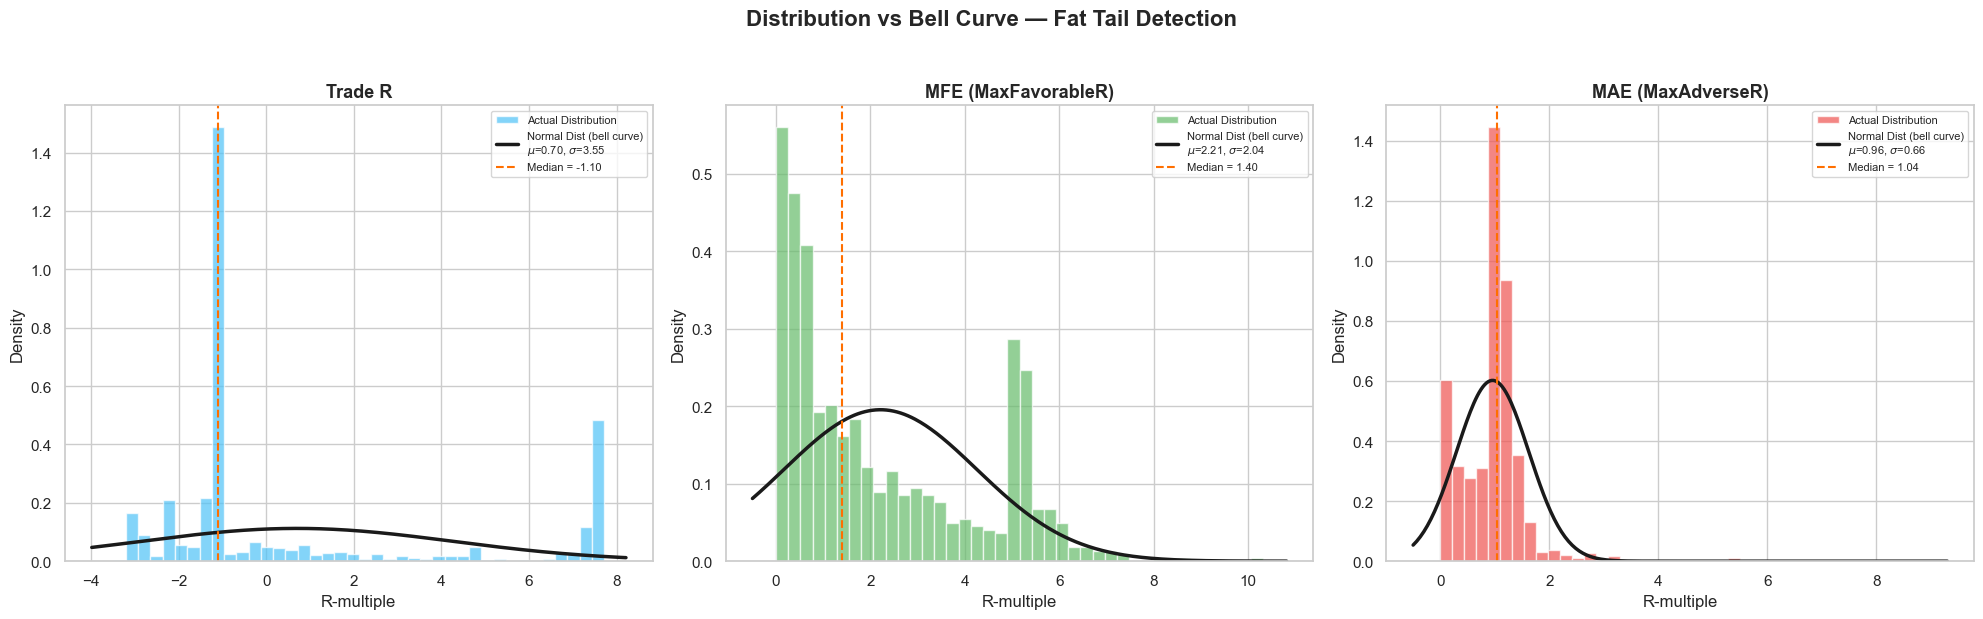

In [14]:
from scipy.stats import norm

if df_trades is not None:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for ax, col, color, label in zip(
        axes,
        ['R', 'MaxFavorableR', 'MaxAdverseR'],
        ['#4FC3F7', '#66BB6A', '#EF5350'],
        ['Trade R', 'MFE (MaxFavorableR)', 'MAE (MaxAdverseR)']
    ):
        data = df_trades[col].dropna()
        
        # Plot histogram (density=True so we can overlay the bell curve)
        n, bins, patches = ax.hist(data, bins=40, density=True,
                                   color=color, edgecolor='white', alpha=0.7,
                                   label='Actual Distribution')
        
        # Overlay normal (bell) curve
        mu, std = data.mean(), data.std()
        x = np.linspace(data.min() - 0.5, data.max() + 0.5, 300)
        bell_curve = norm.pdf(x, mu, std)
        ax.plot(x, bell_curve, 'k-', linewidth=2.5, label=f'Normal Dist (bell curve)\n$\\mu$={mu:.2f}, $\\sigma$={std:.2f}')
        
        # Mark the median
        ax.axvline(data.median(), color='#FF6F00', linestyle='--', linewidth=1.5,
                   label=f'Median = {data.median():.2f}')
        
        ax.set_title(label, fontsize=13, fontweight='bold')
        ax.set_xlabel('R-multiple')
        ax.set_ylabel('Density')
        ax.legend(fontsize=8)

    plt.suptitle('Distribution vs Bell Curve — Fat Tail Detection',
                 fontsize=16, fontweight='bold', y=1.03)
    plt.tight_layout()
    plt.show()

## Fat-Tail Bell Curve Deep Dive
**Each distribution plotted individually with its theoretical normal (bell) curve.**
Areas where the actual bars extend beyond the bell curve = **fat tails** (extreme events happening more often than normal models predict).

- **R distribution** is capped by TP/SL, so tails are truncated
- **MFE (Max Favorable Excursion)** shows how far price runs in your favor — fat right tail = market regularly runs past your TP
- **MAE (Max Adverse Excursion)** shows how far price moves against you — fat right tail = outlier adverse moves

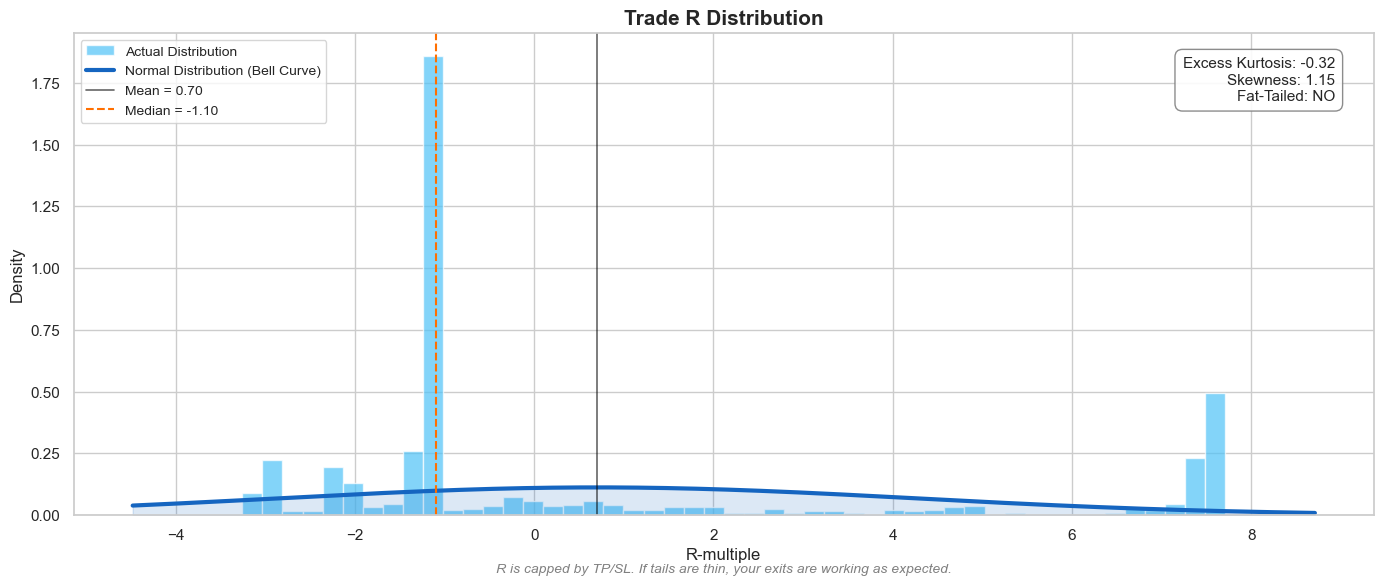

In [15]:
if df_trades is not None:
    data = df_trades['R'].dropna()
    mu, std = data.mean(), data.std()
    kurt = data.kurtosis()  # excess kurtosis (Fisher)
    skew = data.skew()

    fig, ax = plt.subplots(figsize=(14, 6))

    # Histogram
    n, bins, patches = ax.hist(data, bins=50, density=True,
                               color='#4FC3F7', edgecolor='white', alpha=0.7,
                               label='Actual Distribution')

    # Bell curve overlay
    x = np.linspace(data.min() - 1, data.max() + 1, 500)
    bell = norm.pdf(x, mu, std)
    ax.plot(x, bell, color='#1565C0', linewidth=3, label='Normal Distribution (Bell Curve)')

    # Fill the area between to highlight fat tails
    ax.fill_between(x, bell, alpha=0.15, color='#1565C0')

    # Annotations
    ax.axvline(mu, color='black', linestyle='-', linewidth=1.2, alpha=0.6, label=f'Mean = {mu:.2f}')
    ax.axvline(data.median(), color='#FF6F00', linestyle='--', linewidth=1.5, label=f'Median = {data.median():.2f}')

    # Stats box
    stats_text = f'Excess Kurtosis: {kurt:.2f}\nSkewness: {skew:.2f}\n'
    stats_text += f'Fat-Tailed: {"YES" if kurt > 0 else "NO"}'
    ax.text(0.97, 0.95, stats_text, transform=ax.transAxes,
            fontsize=11, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='gray'))

    ax.set_title('Trade R Distribution', fontsize=15, fontweight='bold')
    ax.set_xlabel('R-multiple', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.legend(loc='upper left', fontsize=10)

    # Subtitle
    ax.text(0.5, -0.12, 'R is capped by TP/SL. If tails are thin, your exits are working as expected.',
            transform=ax.transAxes, fontsize=10, ha='center', style='italic', color='gray')

    plt.tight_layout()
    plt.show()

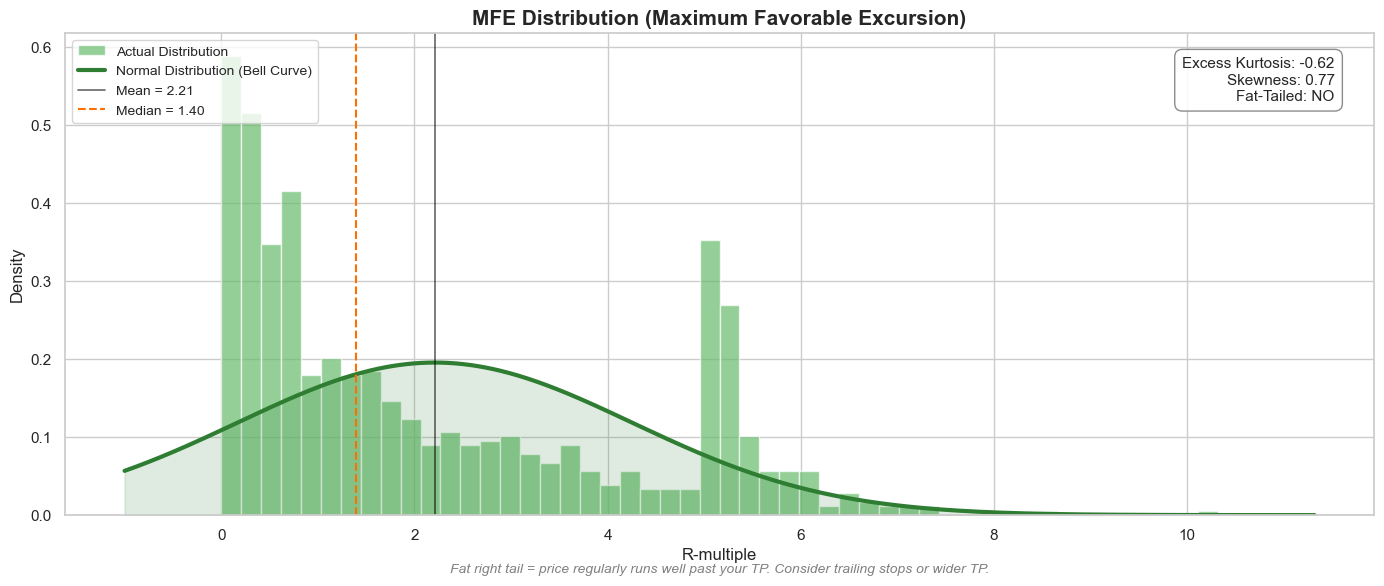

In [16]:
if df_trades is not None:
    data = df_trades['MaxFavorableR'].dropna()
    mu, std = data.mean(), data.std()
    kurt = data.kurtosis()  # excess kurtosis (Fisher)
    skew = data.skew()

    fig, ax = plt.subplots(figsize=(14, 6))

    # Histogram
    n, bins, patches = ax.hist(data, bins=50, density=True,
                               color='#66BB6A', edgecolor='white', alpha=0.7,
                               label='Actual Distribution')

    # Bell curve overlay
    x = np.linspace(data.min() - 1, data.max() + 1, 500)
    bell = norm.pdf(x, mu, std)
    ax.plot(x, bell, color='#2E7D32', linewidth=3, label='Normal Distribution (Bell Curve)')

    # Fill the area between to highlight fat tails
    ax.fill_between(x, bell, alpha=0.15, color='#2E7D32')

    # Annotations
    ax.axvline(mu, color='black', linestyle='-', linewidth=1.2, alpha=0.6, label=f'Mean = {mu:.2f}')
    ax.axvline(data.median(), color='#FF6F00', linestyle='--', linewidth=1.5, label=f'Median = {data.median():.2f}')

    # Stats box
    stats_text = f'Excess Kurtosis: {kurt:.2f}\nSkewness: {skew:.2f}\n'
    stats_text += f'Fat-Tailed: {"YES" if kurt > 0 else "NO"}'
    ax.text(0.97, 0.95, stats_text, transform=ax.transAxes,
            fontsize=11, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='gray'))

    ax.set_title('MFE Distribution (Maximum Favorable Excursion)', fontsize=15, fontweight='bold')
    ax.set_xlabel('R-multiple', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.legend(loc='upper left', fontsize=10)

    # Subtitle
    ax.text(0.5, -0.12, 'Fat right tail = price regularly runs well past your TP. Consider trailing stops or wider TP.',
            transform=ax.transAxes, fontsize=10, ha='center', style='italic', color='gray')

    plt.tight_layout()
    plt.show()

===== RISK INTEGRITY CHECK =====
Minimum R observed: -3.48
Trades worse than -1R: 555 (64.16%)
⚠️ WARNING: Risk exceeds 1R due to scale-ins.



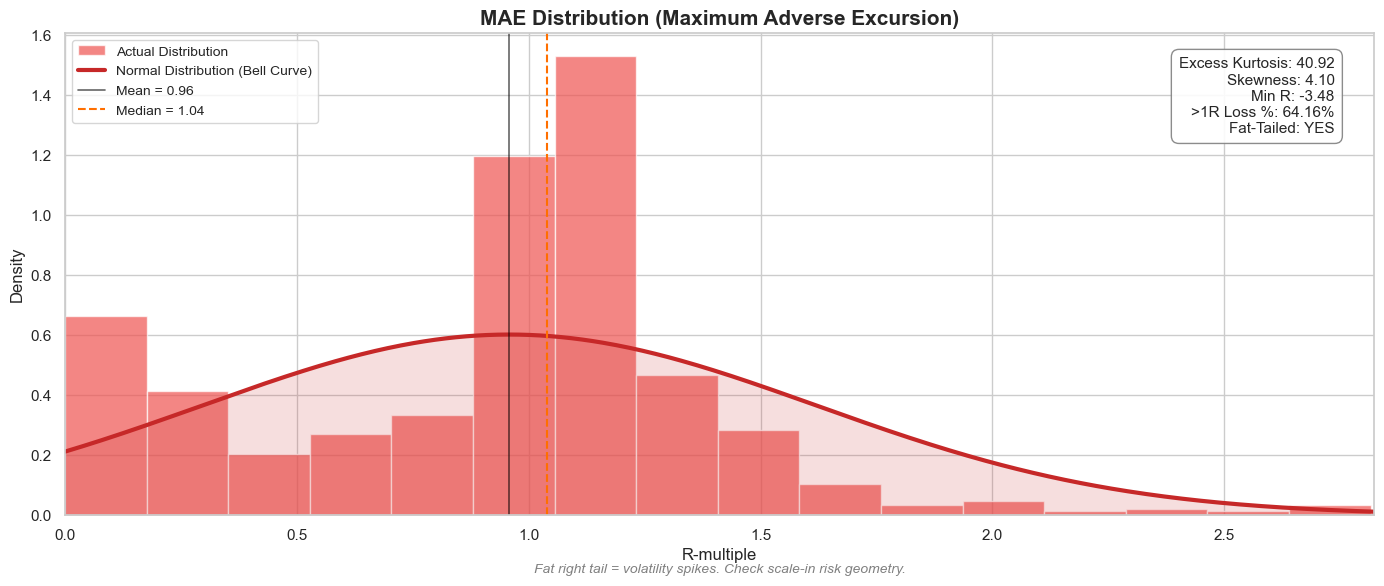

In [17]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

if df_trades is not None:

    # =========================
    # 1️⃣ MAE Distribution Stats
    # =========================
    data = df_trades['MaxAdverseR'].dropna()
    mu, std = data.mean(), data.std()
    kurt = data.kurtosis()  # excess kurtosis
    skew = data.skew()

    # =========================
    # 2️⃣ SL / Risk Integrity Check
    # =========================
    min_R = df_trades['R'].min()
    worst_losses = df_trades[df_trades['R'] < -1]['R']
    pct_over_1R = len(worst_losses) / len(df_trades) * 100

    print("===== RISK INTEGRITY CHECK =====")
    print(f"Minimum R observed: {min_R:.2f}")
    print(f"Trades worse than -1R: {len(worst_losses)} ({pct_over_1R:.2f}%)")

    if min_R < -1:
        print("⚠️ WARNING: Risk exceeds 1R due to scale-ins.")
    else:
        print("✅ Risk capped at 1R.")

    print("=================================\n")

    # =========================
    # 3️⃣ Plot
    # =========================
    fig, ax = plt.subplots(figsize=(14, 6))

    # Optional: Zoom for clarity (hide extreme outliers visually)
    p_low = np.percentile(data, 1)
    p_high = np.percentile(data, 99)
    ax.set_xlim(p_low, p_high)

    # Histogram
    n, bins, patches = ax.hist(
        data, bins=50, density=True,
        color='#EF5350', edgecolor='white', alpha=0.7,
        label='Actual Distribution'
    )

    # Bell curve overlay (zoomed range)
    x = np.linspace(p_low, p_high, 500)
    bell = norm.pdf(x, mu, std)
    ax.plot(x, bell, color='#C62828', linewidth=3,
            label='Normal Distribution (Bell Curve)')

    ax.fill_between(x, bell, alpha=0.15, color='#C62828')

    # Mean & Median
    ax.axvline(mu, color='black', linestyle='-',
               linewidth=1.2, alpha=0.6,
               label=f'Mean = {mu:.2f}')

    ax.axvline(data.median(), color='#FF6F00',
               linestyle='--', linewidth=1.5,
               label=f'Median = {data.median():.2f}')

    # Stats box
    stats_text = (
        f'Excess Kurtosis: {kurt:.2f}\n'
        f'Skewness: {skew:.2f}\n'
        f'Min R: {min_R:.2f}\n'
        f'>1R Loss %: {pct_over_1R:.2f}%\n'
        f'Fat-Tailed: {"YES" if kurt > 0 else "NO"}'
    )

    ax.text(
        0.97, 0.95, stats_text,
        transform=ax.transAxes,
        fontsize=11,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.5',
                  facecolor='white',
                  alpha=0.9,
                  edgecolor='gray')
    )

    ax.set_title(
        'MAE Distribution (Maximum Adverse Excursion)',
        fontsize=15,
        fontweight='bold'
    )
    ax.set_xlabel('R-multiple', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.legend(loc='upper left', fontsize=10)

    ax.text(
        0.5, -0.12,
        'Fat right tail = volatility spikes. Check scale-in risk geometry.',
        transform=ax.transAxes,
        fontsize=10,
        ha='center',
        style='italic',
        color='gray'
    )

    plt.tight_layout()
    plt.show()


## 2. MFE vs Actual R (Scatter)
**Institutional Check:** Points well above the diagonal = trades that ran far beyond your TP. Cluster density tells you how much edge you're leaving on the table.

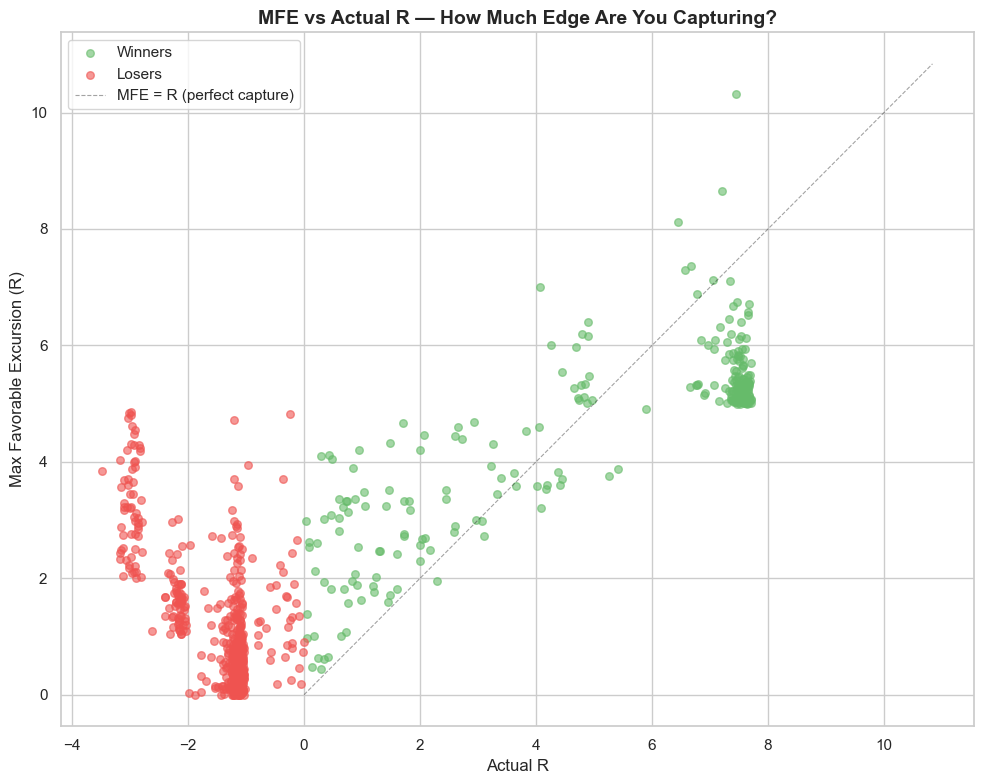

In [18]:
if df_trades is not None:
    fig, ax = plt.subplots(figsize=(10, 8))
    winners = df_trades[df_trades['R'] > 0]
    losers  = df_trades[df_trades['R'] <= 0]

    ax.scatter(winners['R'], winners['MaxFavorableR'], c='#66BB6A', alpha=0.6, s=30, label='Winners')
    ax.scatter(losers['R'],  losers['MaxFavorableR'],  c='#EF5350', alpha=0.6, s=30, label='Losers')

    # Diagonal reference
    lim = max(df_trades['R'].max(), df_trades['MaxFavorableR'].max()) * 1.05
    ax.plot([0, lim], [0, lim], 'k--', linewidth=0.8, alpha=0.4, label='MFE = R (perfect capture)')

    ax.set_xlabel('Actual R', fontsize=12)
    ax.set_ylabel('Max Favorable Excursion (R)', fontsize=12)
    ax.set_title('MFE vs Actual R — How Much Edge Are You Capturing?', fontsize=14, fontweight='bold')
    ax.legend()
    plt.tight_layout()
    plt.show()

## 3. MAE Survival Analysis
**Institutional Check:** Of eventual winners, what % dipped beyond various MAE thresholds before recovering? High survival at deep MAE = your SL is well-placed and absorbs noise.

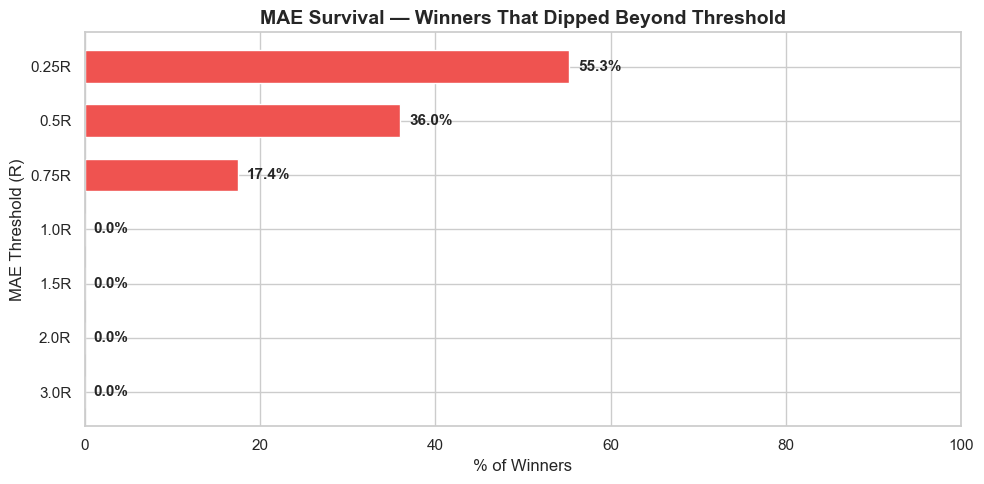

In [19]:
if df_mae_surv is not None:
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.barh(
        df_mae_surv['MAE_Threshold_R'].astype(str) + 'R',
        df_mae_surv['PctOfWinners'] * 100,
        color='#EF5350', edgecolor='white', height=0.6
    )
    for bar, pct in zip(bars, df_mae_surv['PctOfWinners'] * 100):
        ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{pct:.1f}%', va='center', fontsize=11, fontweight='bold')
    ax.set_xlabel('% of Winners', fontsize=12)
    ax.set_ylabel('MAE Threshold (R)', fontsize=12)
    ax.set_title('MAE Survival — Winners That Dipped Beyond Threshold', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 100)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

## 4. TP Capture Efficiency (Per Pair)
**Institutional Check:** A capture ratio near 100% means your TP is well-calibrated. Much below 100% means the market regularly runs past your TP — you may want a trailing stop or wider TP.

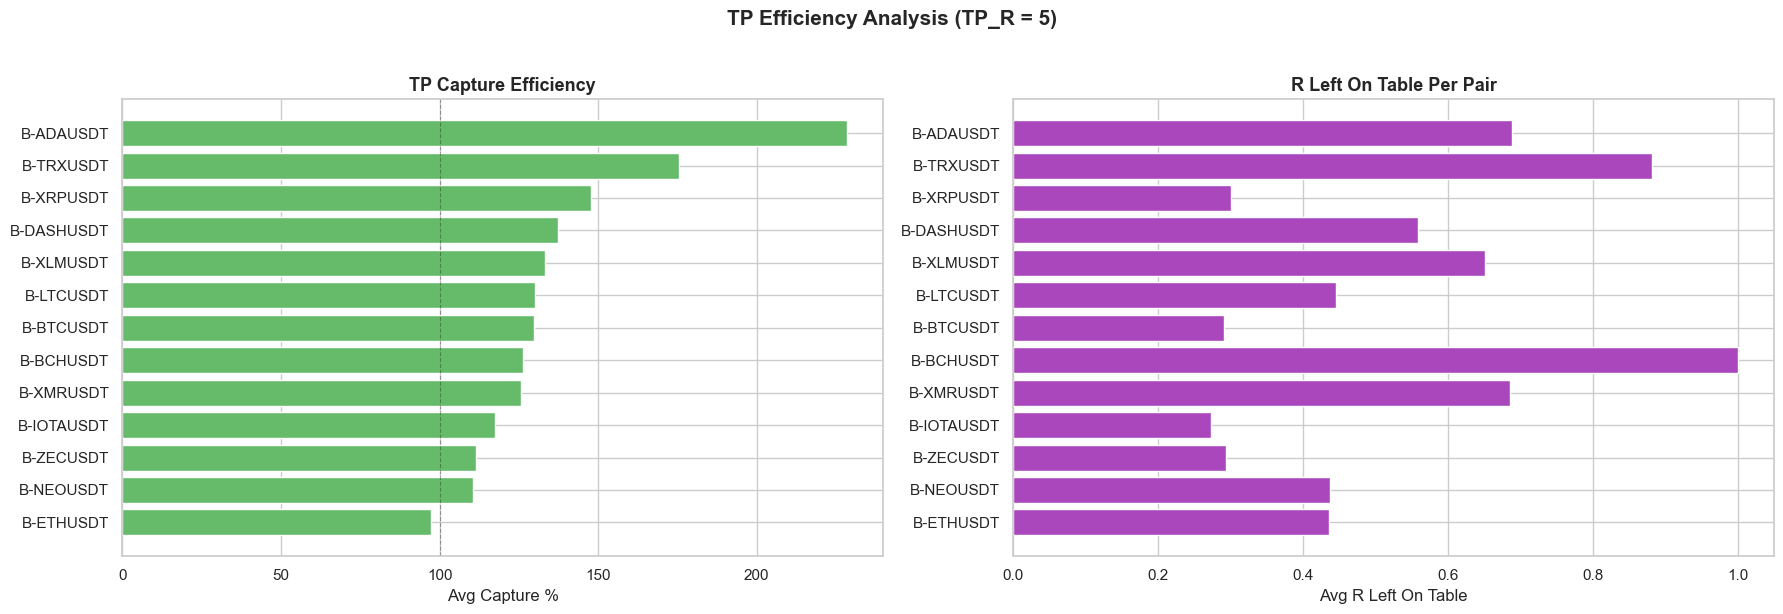

In [20]:
if df_tp_eff is not None:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    pair_rows = df_tp_eff[df_tp_eff['Scope'] != 'GLOBAL'].copy()
    pair_rows = pair_rows.sort_values('AvgCapture', ascending=True)

    # Left: Avg capture %
    colors_cap = ['#66BB6A' if v >= 0.8 else '#FFA726' if v >= 0.5 else '#EF5350'
                  for v in pair_rows['AvgCapture']]
    axes[0].barh(pair_rows['Scope'], pair_rows['AvgCapture'] * 100, color=colors_cap, edgecolor='white')
    axes[0].set_xlabel('Avg Capture %')
    axes[0].set_title('TP Capture Efficiency', fontsize=13, fontweight='bold')
    axes[0].axvline(100, color='black', linestyle='--', linewidth=0.8, alpha=0.3)

    # Right: Avg R left on table
    axes[1].barh(pair_rows['Scope'], pair_rows['LeftOnTableAvgR'], color='#AB47BC', edgecolor='white')
    axes[1].set_xlabel('Avg R Left On Table')
    axes[1].set_title('R Left On Table Per Pair', fontsize=13, fontweight='bold')

    plt.suptitle(f'TP Efficiency Analysis (TP_R = {pair_rows["TP_R"].iloc[0]})', fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

## 5. Excess Kurtosis Heatmap (Per Pair)
**Interpretation:** Excess kurtosis > 0 = fat-tailed. Higher values = more extreme outlier risk. Compare R (capped by TP/SL) vs raw MFE/MAE.

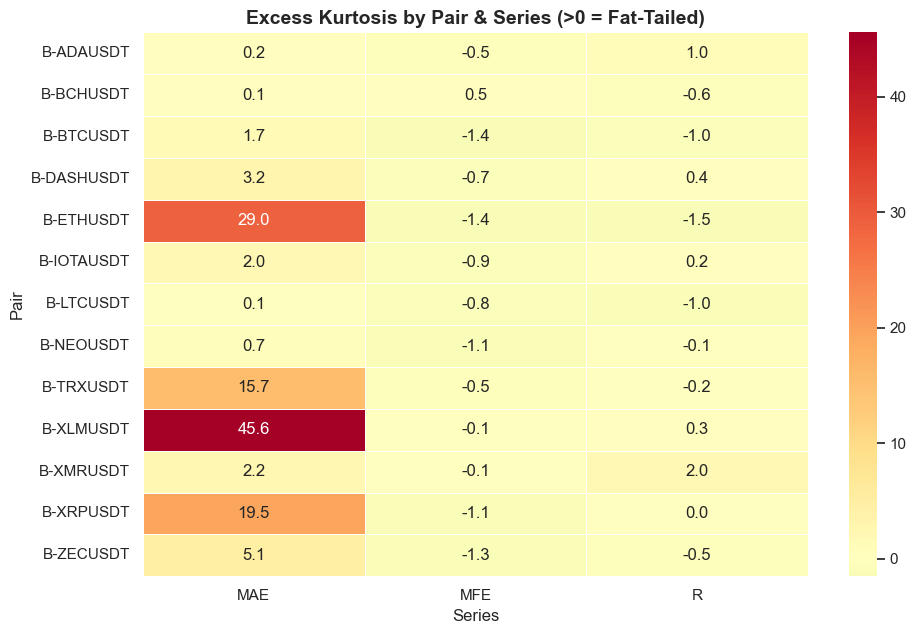

In [21]:
if df_analytics is not None:
    # Build a pivot: rows = pair, columns = series (R / MFE / MAE)
    df_kurt = df_analytics[['Scope', 'ExcessKurtosis']].copy()
    df_kurt['Pair'] = df_kurt['Scope'].str.rsplit('_', n=1).str[0]
    df_kurt['Series'] = df_kurt['Scope'].str.rsplit('_', n=1).str[1]
    df_kurt = df_kurt[df_kurt['Pair'] != 'GLOBAL']
    pivot = df_kurt.pivot(index='Pair', columns='Series', values='ExcessKurtosis')

    fig, ax = plt.subplots(figsize=(10, max(6, len(pivot) * 0.5)))
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn_r', center=0, linewidths=0.5, ax=ax)
    ax.set_title('Excess Kurtosis by Pair & Series (>0 = Fat-Tailed)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 6. Skewness Comparison (Per Pair)
**Interpretation:** Positive skew = right tail is heavier (more big wins). Negative skew = left tail is heavier (more big losses). Compare across pairs to find which coins have the most asymmetric distributions.

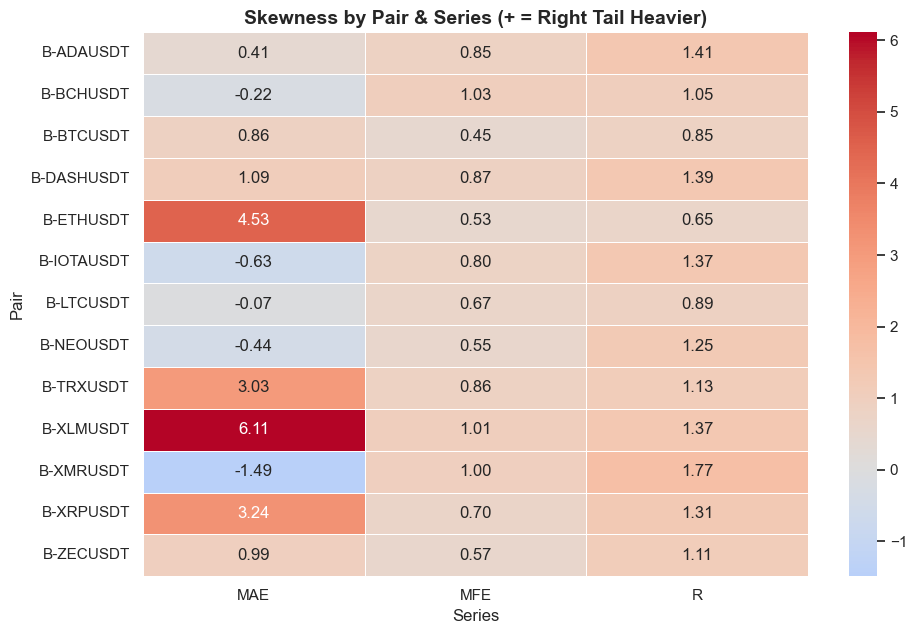

In [22]:
if df_analytics is not None:
    df_skew = df_analytics[['Scope', 'Skewness']].copy()
    df_skew['Pair'] = df_skew['Scope'].str.rsplit('_', n=1).str[0]
    df_skew['Series'] = df_skew['Scope'].str.rsplit('_', n=1).str[1]
    df_skew = df_skew[df_skew['Pair'] != 'GLOBAL']
    pivot_skew = df_skew.pivot(index='Pair', columns='Series', values='Skewness')

    fig, ax = plt.subplots(figsize=(10, max(6, len(pivot_skew) * 0.5)))
    sns.heatmap(pivot_skew, annot=True, fmt='.2f', cmap='coolwarm', center=0, linewidths=0.5, ax=ax)
    ax.set_title('Skewness by Pair & Series (+ = Right Tail Heavier)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

---
# 🎲 Monte Carlo V2 — Institutional Risk Analysis
**4 simulation models compared:** IID Shuffle (baseline), Block Bootstrap (streak-preserving), Correlation-Preserving (cross-pair clustering), and Stress Injection (edge decay + loss streaks).

Data source: `mc_v2_report_long.json` and `mc_v2_comparison.csv`

In [23]:
import json
import numpy as np

# Load MC V2 report
mc_path = os.path.join(DATA_DIR, 'mc_v2_report_long.json')
try:
    with open(mc_path, 'r') as f:
        mc_data = json.load(f)
    print(f'✅ Loaded MC V2 data: {len(mc_data["models"])} models')
    for m in mc_data['models']:
        print(f"   {m['name']:20s} | 1% DD: {m['stats']['pct1DD']:6.1f}R | 5% DD: {m['stats']['pct5DD']:6.1f}R | Median Equity: {m['stats']['medianEquity']:8.1f}R | RoR: {m['stats']['riskOfRuin']}")
except FileNotFoundError:
    mc_data = None
    print('❌ mc_v2_report_long.json not found. Run backtest/run.js first.')

✅ Loaded MC V2 data: 4 models
   IID Shuffle          | 1% DD:   56.8R | 5% DD:   47.9R | Median Equity:    608.2R | RoR: 0.02%
   Block Bootstrap      | 1% DD:   65.3R | 5% DD:   53.0R | Median Equity:    619.4R | RoR: 0.00%
   Correl-Preserve      | 1% DD:   81.1R | 5% DD:   64.9R | Median Equity:    602.6R | RoR: 0.06%
   Stress Injected      | 1% DD:  222.6R | 5% DD:  174.5R | Median Equity:     42.0R | RoR: 36.80%


## 1. Drawdown Distribution Overlay
**All 4 MC models on one chart.** Vertical lines show 1% and 5% worst-case DD for each model.

- 🔵 IID = baseline (assumes trades are independent)
- 🟢 Block Bootstrap = preserves losing streaks
- 🟠 Correlation-Preserving = preserves cross-pair clustering
- 🔴 Stress = edge decay + injected loss streaks

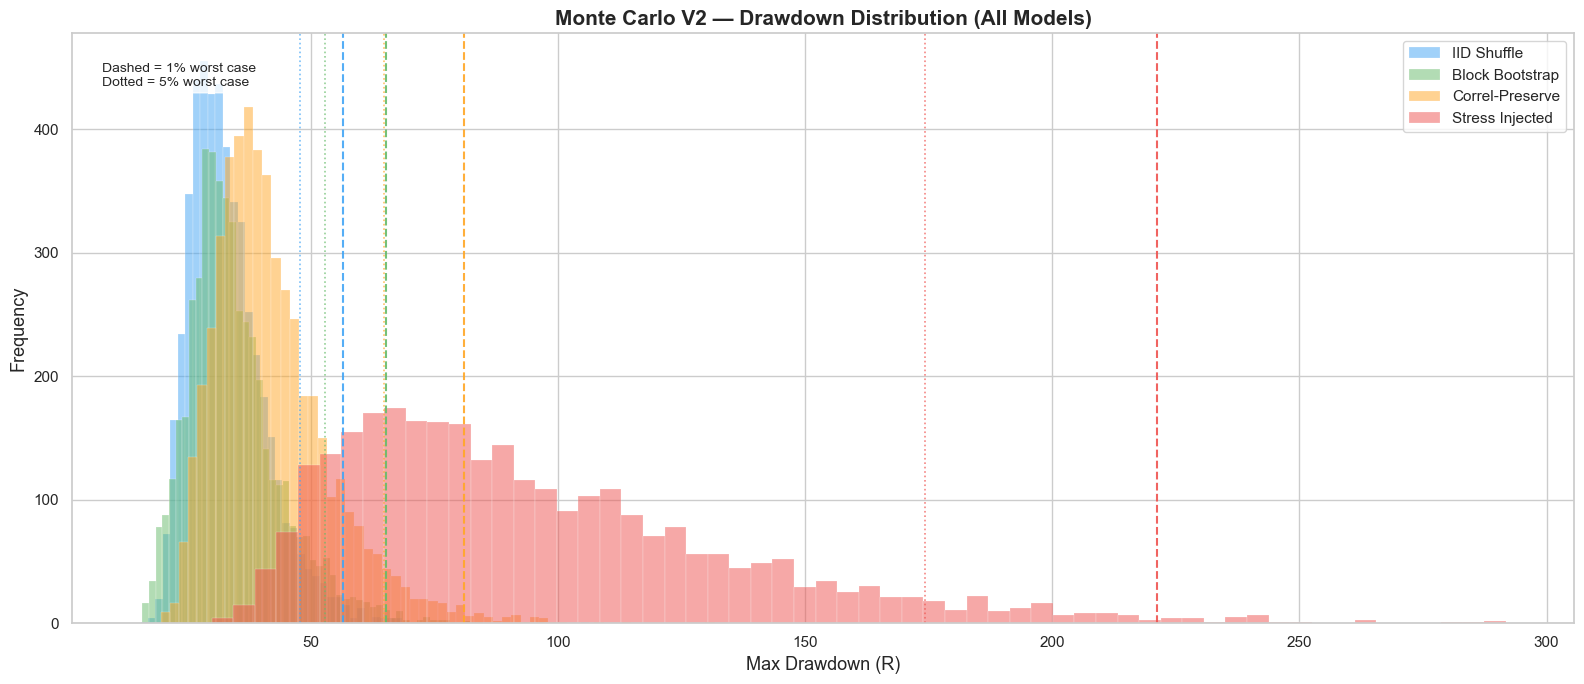

In [24]:
if mc_data is not None:
    fig, ax = plt.subplots(figsize=(16, 7))

    model_keys = ['iid', 'block', 'correlated', 'stress']
    model_names = ['IID Shuffle', 'Block Bootstrap', 'Correl-Preserve', 'Stress Injected']
    colors = ['#42A5F5', '#66BB6A', '#FFA726', '#EF5350']
    alphas = [0.5, 0.5, 0.5, 0.5]

    for key, name, color, alpha in zip(model_keys, model_names, colors, alphas):
        dds = mc_data['drawdowns'][key]
        ax.hist(dds, bins=60, alpha=alpha, color=color, label=name, edgecolor='white', linewidth=0.3)

        # 1% and 5% lines
        pct1 = np.percentile(dds, 99)
        pct5 = np.percentile(dds, 95)
        ax.axvline(pct1, color=color, linestyle='--', linewidth=1.5, alpha=0.9)
        ax.axvline(pct5, color=color, linestyle=':', linewidth=1.2, alpha=0.7)

    ax.set_xlabel('Max Drawdown (R)', fontsize=13)
    ax.set_ylabel('Frequency', fontsize=13)
    ax.set_title('Monte Carlo V2 — Drawdown Distribution (All Models)', fontsize=15, fontweight='bold')
    ax.legend(fontsize=11, loc='upper right')

    # Add text annotation
    ax.text(0.02, 0.95, 'Dashed = 1% worst case\nDotted = 5% worst case',
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

## 2. Equity Path Fan Chart
**50 sample equity curves per model.** The "fan" spread shows the range of possible outcomes.

Tighter fan = more predictable. Wider fan = more uncertain. The stress model should show the widest spread.

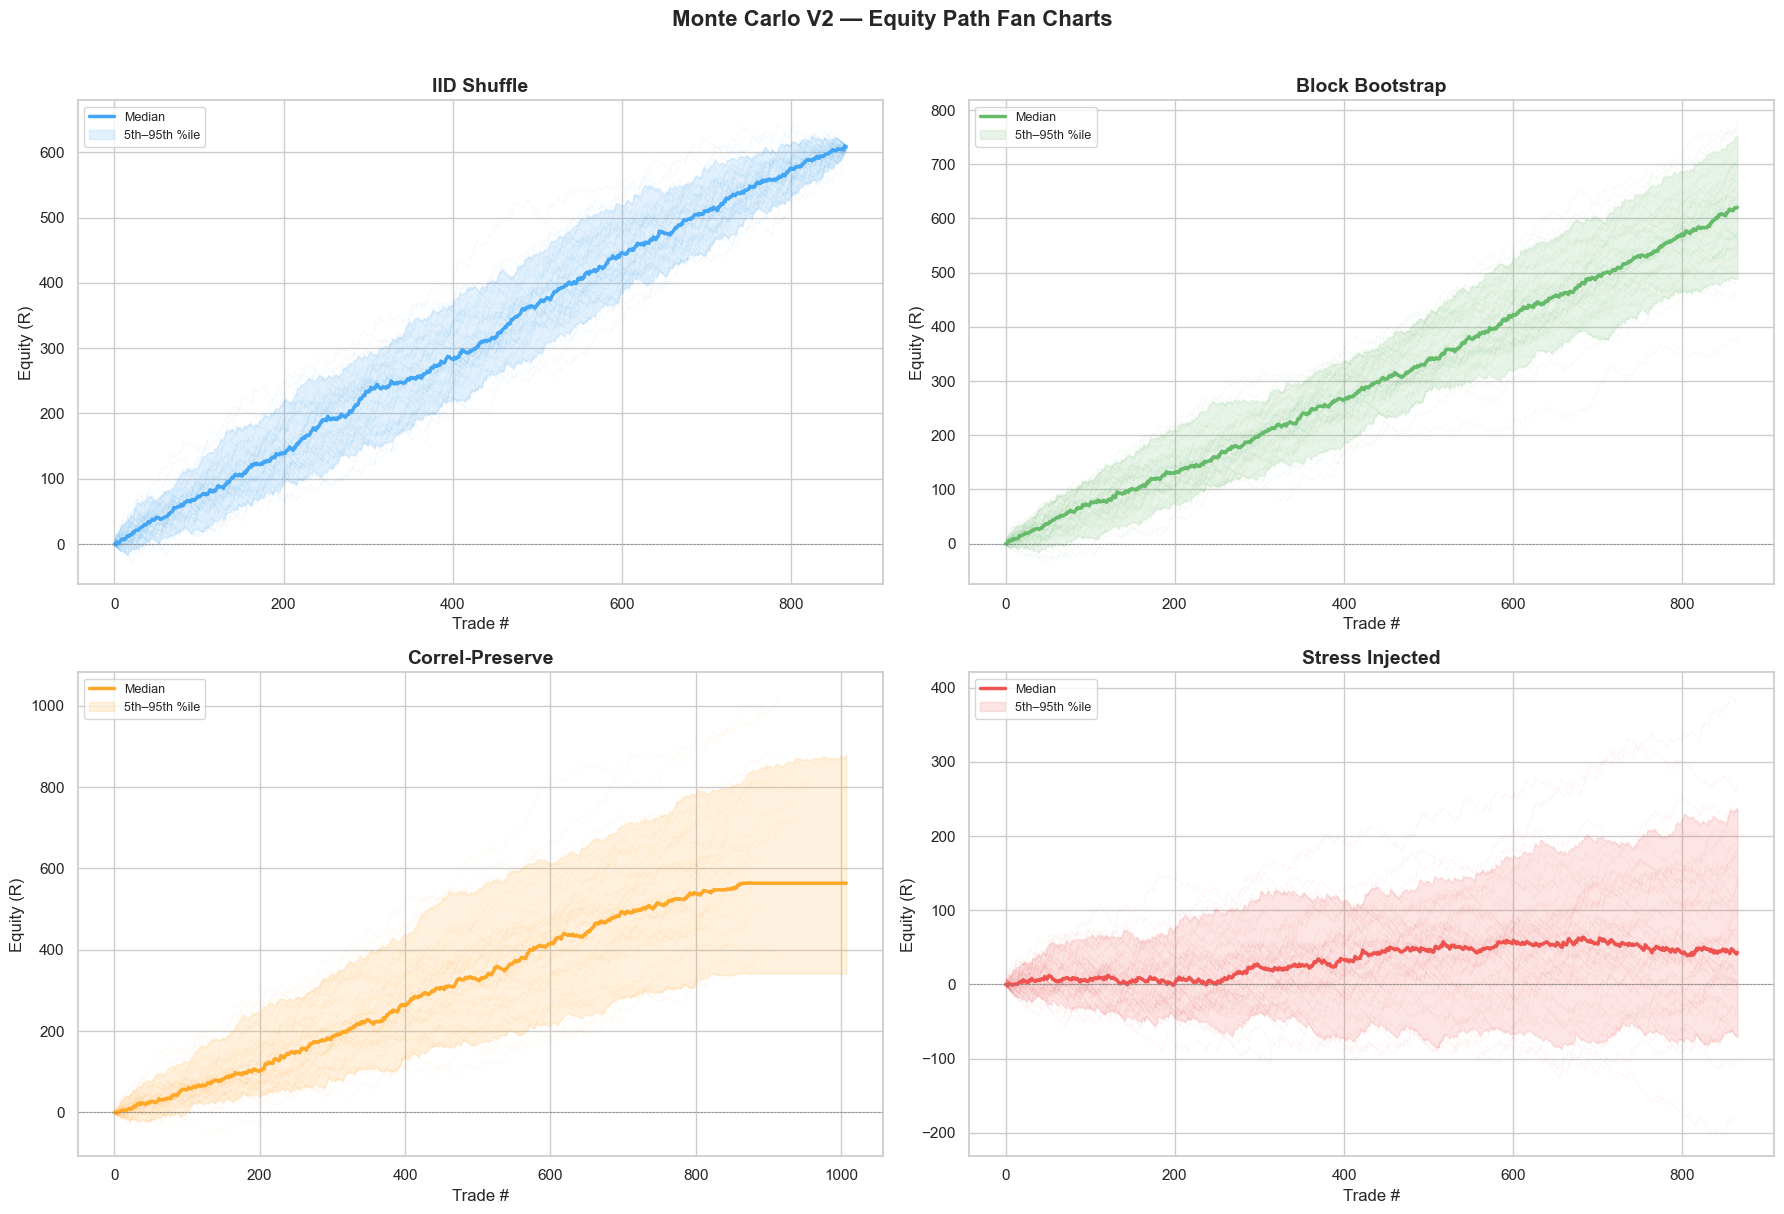

In [25]:
if mc_data is not None:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()

    model_keys = ['iid', 'block', 'correlated', 'stress']
    model_names = ['IID Shuffle', 'Block Bootstrap', 'Correl-Preserve', 'Stress Injected']
    colors = ['#42A5F5', '#66BB6A', '#FFA726', '#EF5350']

    for ax, key, name, color in zip(axes, model_keys, model_names, colors):
        paths = mc_data['paths'][key]

        # Plot each path with low alpha
        for path in paths:
            ax.plot(path, color=color, alpha=0.08, linewidth=0.5)

        # Compute and plot median path
        max_len = max(len(p) for p in paths)
        padded = [p + [p[-1]] * (max_len - len(p)) for p in paths]
        median_path = np.median(padded, axis=0)
        ax.plot(median_path, color=color, alpha=1.0, linewidth=2.5, label='Median')

        # 5th and 95th percentile bands
        p5 = np.percentile(padded, 5, axis=0)
        p95 = np.percentile(padded, 95, axis=0)
        x = range(len(median_path))
        ax.fill_between(x, p5, p95, alpha=0.15, color=color, label='5th–95th %ile')

        ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')
        ax.set_title(name, fontsize=14, fontweight='bold')
        ax.set_xlabel('Trade #')
        ax.set_ylabel('Equity (R)')
        ax.legend(fontsize=9, loc='upper left')

    plt.suptitle('Monte Carlo V2 — Equity Path Fan Charts', fontsize=16, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()

## 3. Risk Comparison — Side by Side
**Grouped bars: 1% DD, 5% DD, and Median Equity for each model.**

This is the key chart for capital allocation decisions.

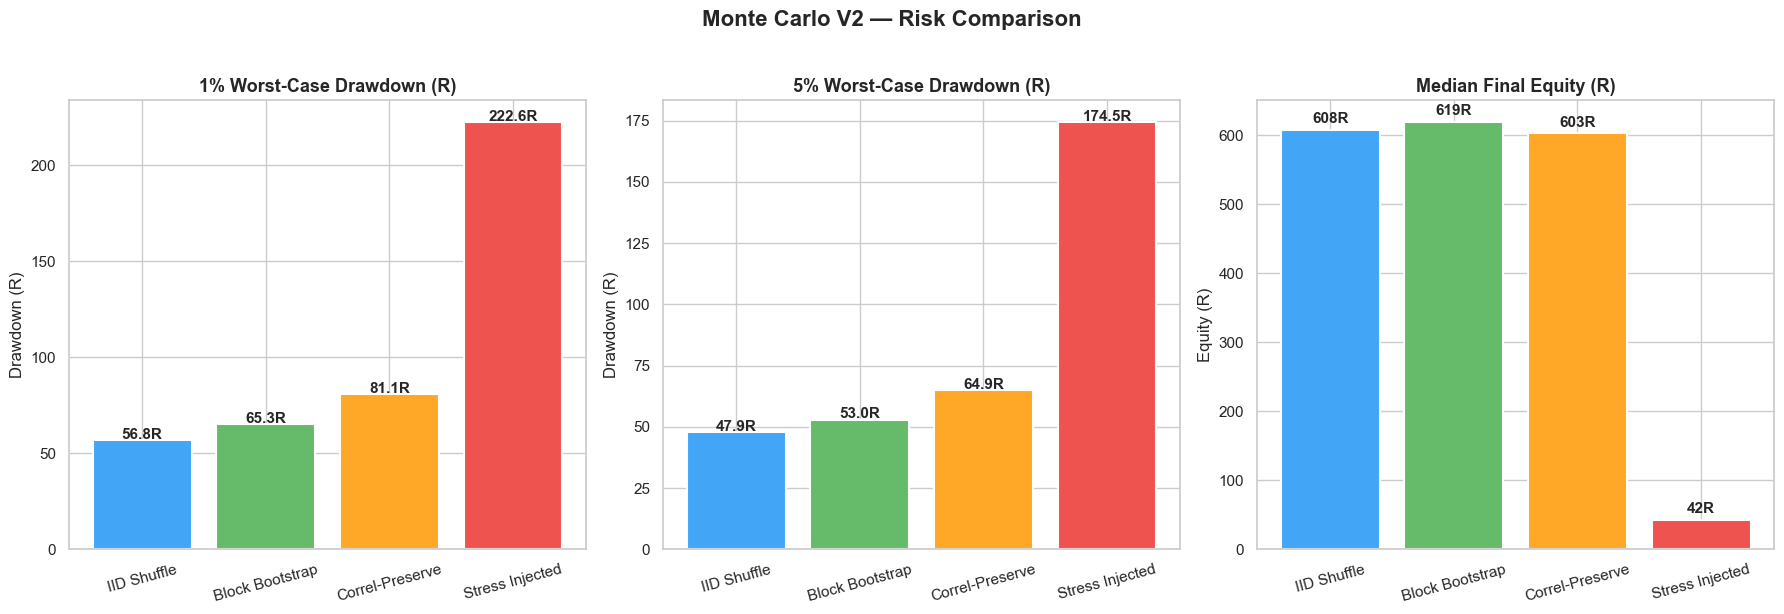

In [26]:
if mc_data is not None:
    models = mc_data['models']
    names = [m['name'] for m in models]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    bar_colors = ['#42A5F5', '#66BB6A', '#FFA726', '#EF5350']

    # 1% Worst DD
    vals = [m['stats']['pct1DD'] for m in models]
    bars = axes[0].bar(names, vals, color=bar_colors, edgecolor='white', linewidth=1.5)
    axes[0].set_title('1% Worst-Case Drawdown (R)', fontsize=13, fontweight='bold')
    axes[0].set_ylabel('Drawdown (R)')
    for bar, v in zip(bars, vals):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                     f'{v:.1f}R', ha='center', fontweight='bold', fontsize=11)

    # 5% Worst DD
    vals = [m['stats']['pct5DD'] for m in models]
    bars = axes[1].bar(names, vals, color=bar_colors, edgecolor='white', linewidth=1.5)
    axes[1].set_title('5% Worst-Case Drawdown (R)', fontsize=13, fontweight='bold')
    axes[1].set_ylabel('Drawdown (R)')
    for bar, v in zip(bars, vals):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                     f'{v:.1f}R', ha='center', fontweight='bold', fontsize=11)

    # Median Final Equity
    vals = [m['stats']['medianEquity'] for m in models]
    bars = axes[2].bar(names, vals, color=bar_colors, edgecolor='white', linewidth=1.5)
    axes[2].set_title('Median Final Equity (R)', fontsize=13, fontweight='bold')
    axes[2].set_ylabel('Equity (R)')
    for bar, v in zip(bars, vals):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                     f'{v:.0f}R', ha='center', fontweight='bold', fontsize=11)

    for ax in axes:
        ax.tick_params(axis='x', rotation=15)

    plt.suptitle('Monte Carlo V2 — Risk Comparison', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

## 4. Stress Test Survival Heatmap
**Simulates different edge-decay levels vs loss-streak lengths.**

Each cell shows what % of simulations survived (final equity > 0) under that stress combination. Green = safe, Red = dangerous.

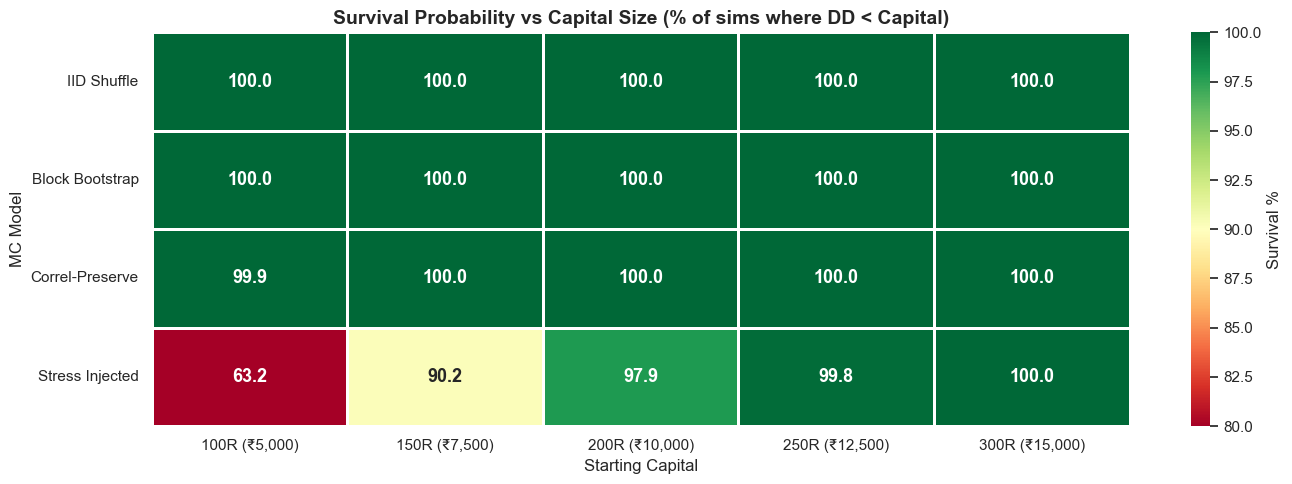


💡 Interpretation:
   100% = all simulations survived at that capital level
   <99% = real risk of account wipeout under that model
   Your current capital: 200R (₹10,000)


In [27]:
if mc_data is not None:
    # Build stress heatmap from drawdown distributions
    # We simulate different capital levels against observed drawdowns
    capital_levels = [100, 150, 200, 250, 300]  # in R
    model_keys = ['iid', 'block', 'correlated', 'stress']
    model_names = ['IID Shuffle', 'Block Bootstrap', 'Correl-Preserve', 'Stress Injected']

    survival_data = []
    for key in model_keys:
        dds = mc_data['drawdowns'][key]
        row = []
        for cap in capital_levels:
            # % of sims where max DD < capital (survived)
            survived = sum(1 for d in dds if d < cap) / len(dds) * 100
            row.append(survived)
        survival_data.append(row)

    df_surv = pd.DataFrame(
        survival_data,
        index=model_names,
        columns=[f'{c}R (₹{c*50:,})' for c in capital_levels]
    )

    fig, ax = plt.subplots(figsize=(14, 5))
    sns.heatmap(
        df_surv, annot=True, fmt='.1f', cmap='RdYlGn',
        vmin=80, vmax=100, linewidths=1, ax=ax,
        annot_kws={'fontsize': 13, 'fontweight': 'bold'},
        cbar_kws={'label': 'Survival %'}
    )
    ax.set_title('Survival Probability vs Capital Size (% of sims where DD < Capital)',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Starting Capital', fontsize=12)
    ax.set_ylabel('MC Model', fontsize=12)
    plt.tight_layout()
    plt.show()

    print('\n💡 Interpretation:')
    print('   100% = all simulations survived at that capital level')
    print('   <99% = real risk of account wipeout under that model')
    print('   Your current capital: 200R (₹10,000)')

---
# 💰 5-Year Compounding Capital Projection
**Monte Carlo simulation with compound position sizing (0.5% of current equity per trade).**

Three scenarios:
- **Conservative** (Block Bootstrap) — preserves losing streaks
- **Realistic** (Correlation-Preserving) — preserves cross-pair clustering
- **Stress** (Edge Decay + Loss Streaks) — worst-case scenario

Data source: `mc_compounding_report_long.json`

In [28]:
import json
import numpy as np

comp_path = os.path.join(DATA_DIR, 'mc_compounding_report_long.json')
try:
    with open(comp_path, 'r') as f:
        comp_data = json.load(f)
    print(f'✅ Loaded compounding MC data')
    print(f'   Config: ₹{comp_data["config"]["startingCapital"]:,} capital, {comp_data["config"]["riskPct"]*100:.1f}% risk, {comp_data["config"]["targetTrades"]} trades over {comp_data["config"]["projectionYears"]} years')
    for s in comp_data['scenarios']:
        print(f'   {s["name"]:15s} | Median: ₹{s["stats"]["medianFinal"]:>10,.0f} | CAGR: {s["stats"]["medianCAGR"]:.1f}% | Max DD: {s["stats"]["medianMaxDD"]:.1f}% | Blown: {s["stats"]["blownPct"]}%')
except FileNotFoundError:
    comp_data = None
    print('❌ mc_compounding_report_long.json not found. Run backtest/run.js first.')

✅ Loaded compounding MC data
   Config: ₹10,000 capital, 0.5% risk, 608 trades over 5 years
   Conservative    | Median: ₹    79,619 | CAGR: 51.4% | Max DD: 14.4% | Blown: 0.00%
   Realistic       | Median: ₹    76,456 | CAGR: 50.2% | Max DD: 17.0% | Blown: 0.00%
   Stress          | Median: ₹     9,813 | CAGR: -0.4% | Max DD: 34.5% | Blown: 0.00%


## 1. Capital Growth Fan Chart (₹)
**50 sample equity paths per scenario.** Shows how ₹10,000 compounds over 608 trades (~5 years).

Shaded band = 5th–95th percentile. Solid line = median path.

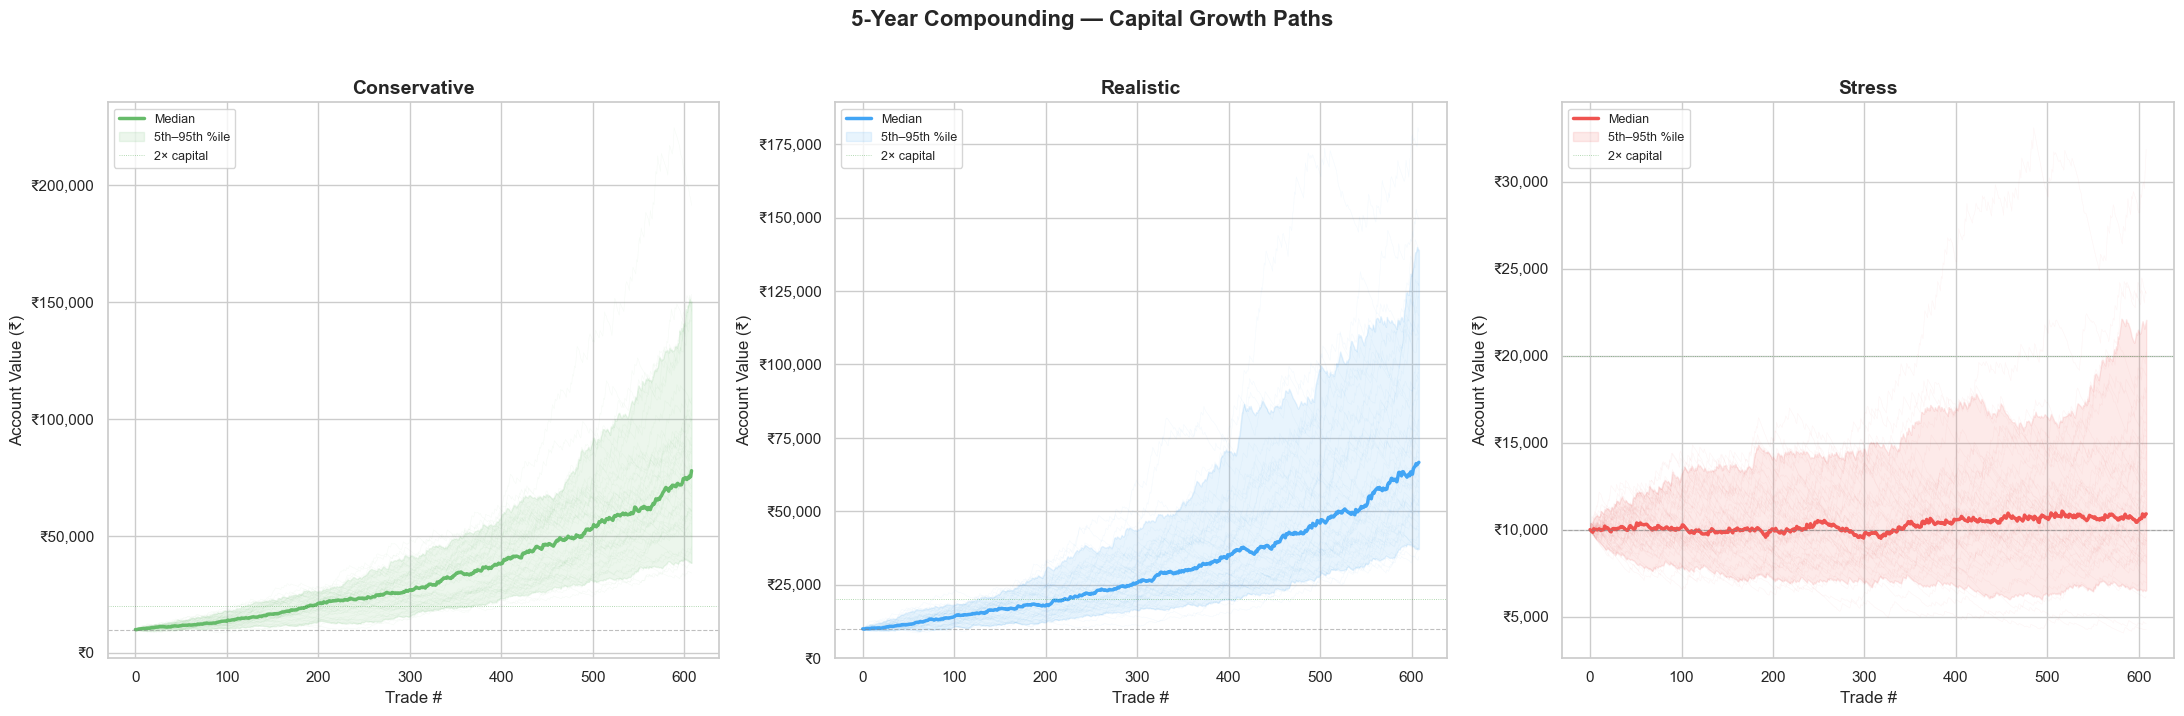

In [29]:
if comp_data is not None:
    fig, axes = plt.subplots(1, 3, figsize=(22, 7))

    scenario_keys = ['conservative', 'realistic', 'stress']
    scenario_names = ['Conservative', 'Realistic', 'Stress']
    colors = ['#66BB6A', '#42A5F5', '#EF5350']

    for ax, key, name, color in zip(axes, scenario_keys, scenario_names, colors):
        paths = comp_data['paths'][key]

        for path in paths:
            ax.plot(path, color=color, alpha=0.06, linewidth=0.4)

        # Compute percentile bands
        max_len = max(len(p) for p in paths)
        padded = [p + [p[-1]] * (max_len - len(p)) for p in paths]
        median_path = np.median(padded, axis=0)
        p5 = np.percentile(padded, 5, axis=0)
        p95 = np.percentile(padded, 95, axis=0)

        x = range(len(median_path))
        ax.plot(median_path, color=color, linewidth=2.5, label='Median')
        ax.fill_between(x, p5, p95, alpha=0.12, color=color, label='5th–95th %ile')

        ax.axhline(10000, color='gray', linewidth=0.8, linestyle='--', alpha=0.5)
        ax.axhline(20000, color='green', linewidth=0.6, linestyle=':', alpha=0.4, label='2× capital')

        # Format y-axis as ₹
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'₹{x:,.0f}'))
        ax.set_title(name, fontsize=14, fontweight='bold')
        ax.set_xlabel('Trade #')
        ax.set_ylabel('Account Value (₹)')
        ax.legend(fontsize=9, loc='upper left')

    plt.suptitle('5-Year Compounding — Capital Growth Paths', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

## 2. Final Capital Distribution
**Histogram of final account values after 5 years (608 trades).** Vertical lines show median.

Key question: What's the realistic range of outcomes?

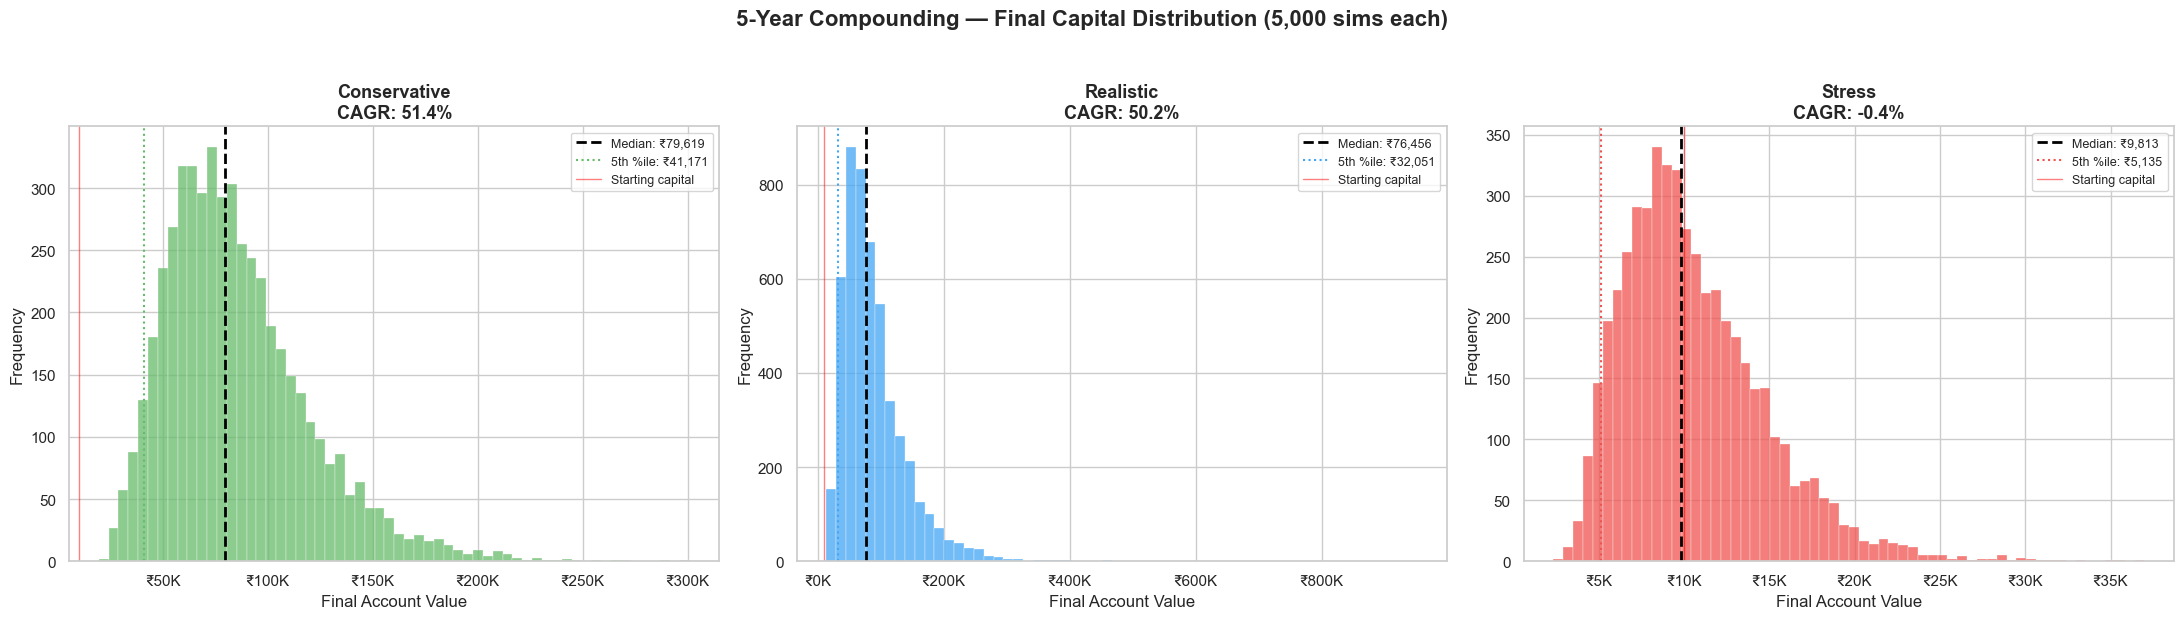

In [30]:
if comp_data is not None:
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))

    scenario_keys = ['conservative', 'realistic', 'stress']
    scenario_names = ['Conservative', 'Realistic', 'Stress']
    colors = ['#66BB6A', '#42A5F5', '#EF5350']

    for ax, key, name, color, scenario_data in zip(
        axes, scenario_keys, scenario_names, colors, comp_data['scenarios']
    ):
        finals = comp_data['finalEquities'][key]
        stats = scenario_data['stats']

        ax.hist(finals, bins=60, color=color, edgecolor='white', alpha=0.75, linewidth=0.3)
        ax.axvline(stats['medianFinal'], color='black', linestyle='--', linewidth=2,
                   label=f'Median: ₹{stats["medianFinal"]:,.0f}')
        ax.axvline(stats['pct5Final'], color=color, linestyle=':', linewidth=1.5,
                   label=f'5th %ile: ₹{stats["pct5Final"]:,.0f}')
        ax.axvline(10000, color='red', linestyle='-', linewidth=1, alpha=0.5,
                   label='Starting capital')

        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'₹{x/1000:.0f}K'))
        ax.set_title(f'{name}\nCAGR: {stats["medianCAGR"]:.1f}%', fontsize=13, fontweight='bold')
        ax.set_xlabel('Final Account Value')
        ax.set_ylabel('Frequency')
        ax.legend(fontsize=9)

    plt.suptitle('5-Year Compounding — Final Capital Distribution (5,000 sims each)',
                 fontsize=16, fontweight='bold', y=1.03)
    plt.tight_layout()
    plt.show()

## 3. Compounding Projection Summary
**All key metrics in one table.**

In [31]:
if comp_data is not None:
    rows = []
    for s in comp_data['scenarios']:
        st = s['stats']
        rows.append({
            'Scenario': s['name'],
            'Median Final (₹)': f"₹{st['medianFinal']:,.0f}",
            '5th %ile (₹)': f"₹{st['pct5Final']:,.0f}",
            '95th %ile (₹)': f"₹{st['pct95Final']:,.0f}",
            'Growth (×)': f"{st['medianFinal']/10000:.1f}×",
            'CAGR': f"{st['medianCAGR']:.1f}%",
            'Max DD%': f"{st['medianMaxDD']:.1f}%",
            '1% Worst DD%': f"{st['pct1MaxDD']:.1f}%",
            'Blown': st['blownPct'] + '%',
            'Reached 2×': st['pctReaching2x'] + '%'
        })
    df_summary = pd.DataFrame(rows).set_index('Scenario')
    display(df_summary.style.set_properties(**{'text-align': 'right'}))

,Median Final (₹),5th %ile (₹),95th %ile (₹),Growth (×),CAGR,Max DD%,1% Worst DD%,Blown,Reached 2×
Scenario,,,,,,,,,
Conservative,"₹79,619","₹41,171","₹150,048",8.0×,51.4%,14.4%,26.8%,0.00%,100.0%
Realistic,"₹76,456","₹32,051","₹186,754",7.6×,50.2%,17.0%,33.5%,0.00%,99.8%
Stress,"₹9,813","₹5,135","₹18,403",1.0×,-0.4%,34.5%,64.7%,0.00%,6.1%
